<a href="https://colab.research.google.com/github/karthikmnkrishna/Loan-default-prediction/blob/Build-Phase-2/Lending_case_Study_combine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lending Club Case Study

## Import Libraries

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import re
sns.set(style='whitegrid')
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load data

In [182]:
path = '/content/drive/My Drive/Masters/loan.csv'
loans = pd.read_csv(path)
print(loans.shape)

(39717, 111)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning

In [183]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


**Info Summary:**
1. There are 39717 enteries (rows of data)
2. 111 columns of which 74 of them are float type, 13 are integer type and 24 are object type. (But there could be some date type, which is to be checked)
3. Column 47 has mixed type as per the warning above, need to be analyzed further later


**Data Clean up**
1. remove all invalid rows (rows which has all column enteries which are NAN)
2. remove all invalid columns (columns which has all row enteries which are NAN)
3. remove all numeric data elements where there is no change in data 
4. remove all string/object columns where data elements are same
5. convert all columns where date type is present to datetime type

### 1. remove all invalid rows 

Remove all the rows which has all column enteries which are NAN

In [184]:
loans.dropna(axis=0, how='all', inplace=True)

### 2. remove all invalid columns 

Remove all columns which has all row enteries which are NAN

In [185]:
loans.dropna(axis=1, how='all', inplace=True)

In [186]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39717 entries, 0 to 39716
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  object 
 6   int_rate                    39717 non-null  object 
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

From above it is clear that more than 50% of the columns did not have data and cannot be used for analysis, But number of data elements(rows or indexes) though has remained same which means we did not have any invalid data points

### 3. remove all columns where there is no variation in data 

There are multiple ways how we can remove the data elements. 
For numeric data we can check for standard deviation to be zero
Check for unique value counts in all columns and if the number of unique values is one, we can drop that columns

In [187]:
loans.drop(loans.loc[:,loans.nunique() == 1].columns, inplace=True, axis=1)

In [188]:
loans.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39717 entries, 0 to 39716
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       39717 non-null  int64  
 1   member_id                39717 non-null  int64  
 2   loan_amnt                39717 non-null  int64  
 3   funded_amnt              39717 non-null  int64  
 4   funded_amnt_inv          39717 non-null  float64
 5   term                     39717 non-null  object 
 6   int_rate                 39717 non-null  object 
 7   installment              39717 non-null  float64
 8   grade                    39717 non-null  object 
 9   sub_grade                39717 non-null  object 
 10  emp_title                37258 non-null  object 
 11  emp_length               38642 non-null  object 
 12  home_ownership           39717 non-null  object 
 13  annual_inc               39717 non-null  float64
 14  verification_status   

There were 9 columns where there were no variation in numeric data(standard deviation is zero) and no change in string data, which are removed

### 4. Convert all the date columns from string to datetime format

In [189]:
import datetime
updateNaT = lambda x : datetime.date(9999, 12,31) if pd.isnull(x) else x

In [190]:
dateColumns = ['issue_d', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']

In [191]:
for col in dateColumns:
  loans[col] = pd.to_datetime(loans[col], format="%b-%y").apply(updateNaT)

**earliest_cr_line** column has mixed date time type

In [192]:
earliest_cr_line_data = loans['earliest_cr_line']
# earliest_cr_line_data = pd.to_datetime(earliest_cr_line_data, format="%b-%y", errors='ignore')

In [379]:
earliest_cr_line_data.head()

0    Jan-85
1    Apr-99
2    Nov-01
3    Feb-96
4    Jan-96
Name: earliest_cr_line, dtype: object

### Clean up column mths_since_last_delinq

Fill value -1 for invalid data

In [194]:
loans.mths_since_last_delinq.fillna(value=-1, inplace=True)
loans.mths_since_last_delinq = loans.mths_since_last_delinq.astype(int)

### clean up column mths_since_last_record

In [195]:
loans.mths_since_last_record.fillna(value=-1, inplace=True)
loans.mths_since_last_record = loans.mths_since_last_record.astype(int)

### Clean up int_rate column

The interest rate column is a string column, which is to be converted to numeric for better analysis.</br>
int_rate column ends with '%' which is to be stripped

In [196]:
loans.int_rate = loans.int_rate.apply(lambda x : float(x[:-1]))

### Clean up revol_util column

The revol_util column also is a string column and ends with '%'. It should be converted into numeric column and invalid columns are to be filled with -1

In [197]:
loans.revol_util.fillna(value='-1%', inplace=True)
loans.revol_util = list(map(lambda x : float(x[:-1]), loans.revol_util.values))

### Clean up **desc** column

In [198]:
loans.desc.fillna(' ' ,inplace= True)
loans['desc'] = loans.desc.str.replace('<br>' , '')
loans['desc'] = loans.desc.str.replace('Borrower added on ' , '')
loans['desc'] = loans.desc.str.replace('(1[0-2]|0[1-9])/(3[01]|[12][0-9]|0[1-9])/(1[0-2]|0[1-9])' , '')
loans['desc'] = loans.desc.str.replace('>' ,'')

### clean up **emp_title** column

The emp_title column where the data is not present can be updated with value of 'Not Given'

In [199]:
loans.emp_title.fillna('Not Given' ,inplace= True)

### clean up **emp_length** column

The invalid enteries of the column is updated with 'Not Given'

In [200]:
loans.emp_length.fillna('Not Given' ,inplace= True)

### clean up **title** & **terms** column

In [201]:
loans.title.fillna('Not Specified', inplace=True)
loans['term']= loans.term.str.strip()

### Clean up pub_rec_bankruptcies column

In [202]:
loans.pub_rec_bankruptcies.fillna(-1.0, inplace=True)

### Handling id, member id and url

In [203]:
loans.agg(['count', 'nunique']).transpose()

,count,nunique
id,39717,39717
member_id,39717,39717
loan_amnt,39717,885
funded_amnt,39717,1041
funded_amnt_inv,39717,8205
term,39717,2
int_rate,39717,371
installment,39717,15383
grade,39717,7
sub_grade,39717,35


The columns **id**, **member_id** and **url** have all the columns values being unique. <br>
So we can easily drop two of the three columns and set one as the index. <br>
So we will retain only **id** column and drop the other two

In [204]:
loans.set_index('id', inplace=True)
loans.drop(columns=['member_id', 'url'], inplace=True)

### Removing columns by observation

From the info earlier, we saw that column **next_pymnt_d** has very less data(1140), but let us plot the payment_status and then conclude

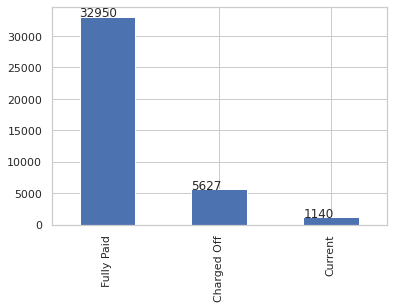

In [205]:
ax = loans.loan_status.value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

From the plot above we can see that, the number of loans with status **Current** is equal to 1140 which is exactly the number of data points in column **next_pymnt_d**

In [206]:
loans[loans.loan_status == 'Current']['next_pymnt_d'].unique()

array([Timestamp('2016-06-01 00:00:00'), Timestamp('2016-07-01 00:00:00')],
      dtype=object)

Since there are only two values and may not be very interesting to analyze, we will delete the column

In [207]:
loans.drop(columns=['next_pymnt_d'], inplace=True)

### Final Data Check

In [208]:
loans.isna().sum()

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
emp_title                  0
emp_length                 0
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
desc                       0
purpose                    0
title                      0
zip_code                   0
addr_state                 0
dti                        0
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             0
mths_since_last_delinq     0
mths_since_last_record     0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_in

Since there are no null columns, missing data is added with default values/ invalid value indicators

## Outlier Analysis

Let us get use the describe function to get the stats of all the numeric columns

In [209]:
loans.describe(percentiles=[0.10, 0.25, 0.50, 0.75, 0.90]).transpose()

,count,mean,std,min,10%,25%,50%,75%,90%,max
loan_amnt,39717.0,11219.443815,7456.670694,500.00,3200.000000,5500.00,10000.000000,15000.00000,22000.000000,3.500000e+04
funded_amnt,39717.0,10947.713196,7187.238670,500.00,3200.000000,5400.00,9600.000000,15000.00000,21000.000000,3.500000e+04
funded_amnt_inv,39717.0,10397.448868,7128.450439,0.00,2950.000000,5000.00,8975.000000,14400.00000,20000.000000,3.500000e+04
int_rate,39717.0,12.021177,3.724825,5.42,7.140000,9.25,11.860000,14.59000,16.890000,2.459000e+01
installment,39717.0,324.561922,208.874874,15.69,99.450000,167.02,280.220000,430.78000,622.952000,1.305190e+03
annual_inc,39717.0,68968.926377,63793.765790,4000.00,30000.000000,40404.00,59000.000000,82300.00000,116000.000000,6.000000e+06
dti,39717.0,13.315130,6.678594,0.00,4.080000,8.17,13.400000,18.60000,22.330000,2.999000e+01
delinq_2yrs,39717.0,0.146512,0.491812,0.00,0.000000,0.00,0.000000,0.00000,1.000000,1.100000e+01
inq_last_6mths,39717.0,0.869200,1.070219,0.00,0.000000,0.00,1.000000,1.00000,2.000000,8.000000e+00
mths_since_last_delinq,39717.0,12.039882,21.965683,-1.00,-1.000000,-1.00,-1.000000,21.00000,48.000000,1.200000e+02


The describe function gives a good overview for all the numeric variables, But each has to be analyzed individually to understand and remove outliers better

### annual_inc

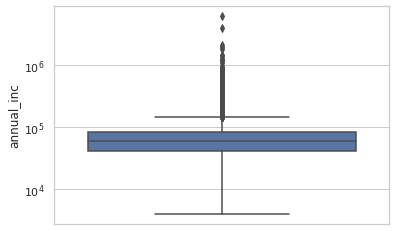

In [210]:
sns.boxplot(y='annual_inc', data=loans)
plt.yscale('log')

In [211]:
quantileRange = [0,0.001,0.01,.025,.05,.1, .25, .5, .75,.975 ,.99,1]

In [212]:
loans.annual_inc.quantile(quantileRange)

0.000    4000.000   
0.001    8408.592   
0.010    14400.000  
0.025    19200.000  
0.050    24000.000  
0.100    30000.000  
0.250    40404.000  
0.500    59000.000  
0.750    82300.000  
0.975    175000.000 
0.990    234999.360 
1.000    6000000.000
Name: annual_inc, dtype: float64

So from the above box plot and values, we can see that there are outliers present in the dataset, so let us take 99% of the data and rest can be left out

In [213]:
loans = loans[loans.annual_inc.between(loans.annual_inc.quantile(0), loans.annual_inc.quantile(.99))]

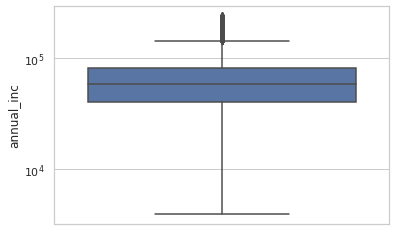

In [214]:
sns.boxplot(y='annual_inc', data=loans)
plt.yscale('log')

Now the outliers in annual_inc is removed

### loan_amnt

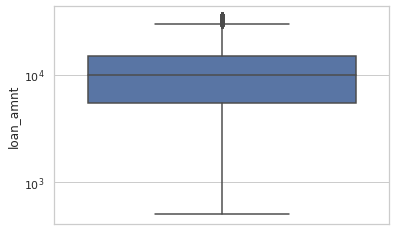

In [215]:
sns.boxplot(y='loan_amnt', data=loans)
plt.yscale('log')

In [216]:
loans.loan_amnt.quantile(quantileRange)

0.000    500.0  
0.001    1000.0 
0.010    1200.0 
0.025    1700.0 
0.050    2400.0 
0.100    3200.0 
0.250    5400.0 
0.500    10000.0
0.750    15000.0
0.975    30000.0
0.990    35000.0
1.000    35000.0
Name: loan_amnt, dtype: float64

There are not many outliers in the loan_amnt, so this column can be used as it is

### installment

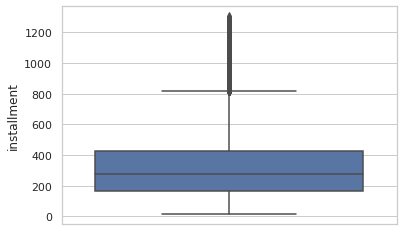

In [217]:
sns.boxplot(y='installment', data=loans)

In [218]:
loans.installment.quantile(quantileRange)

0.000    15.69000  
0.001    28.76314  
0.010    37.56080  
0.025    52.72900  
0.050    71.02000  
0.100    99.26600  
0.250    166.19000 
0.500    278.92000 
0.750    426.10000 
0.975    841.24000 
0.990    921.11000 
1.000    1305.19000
Name: installment, dtype: float64

### dti

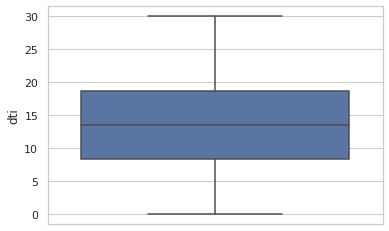

In [219]:
sns.boxplot(y='dti', data=loans)

Clear from boxplot, that there is no outlier

### total_pymnt

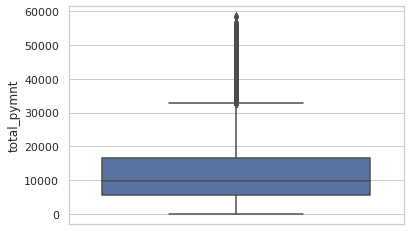

In [220]:
sns.boxplot(y='total_pymnt', data=loans)

In [221]:
loans.total_pymnt.quantile(quantileRange)

0.000    0.000000    
0.001    97.541940   
0.010    759.452600  
0.025    1240.153572 
0.050    1880.992346 
0.100    2956.576386 
0.250    5561.299425 
0.500    9830.255586 
0.750    16429.424275
0.975    35008.490601
0.990    41828.348798
1.000    58563.679930
Name: total_pymnt, dtype: float64

No outliers found

## UNIVARIATE/SEGMENTED UNIVARIATE ANALYSIS

#### Helper functions

##### count plot

In [222]:
def get_totals_count(ax):

    heights = [x.get_height() for x in ax.patches]
    return sum(heights)

In [223]:
def plot_count_chart(ColdataSeries, figsize=(20,10), logScale=False, isPercentage=True):
    sns.set(style="whitegrid")
    plt.figure(figsize=figsize)
    ax = sns.countplot(x=ColdataSeries)
    
    plt.tight_layout()
    patch_totals = get_totals_count(ax)
    for p in ax.patches:
      if isPercentage:
        ax.annotate('{:.2f}% ({})'.format(p.get_height()*100/patch_totals, 
                                          int(p.get_height())),
                    (p.get_x() * 1.005, p.get_height() * 1.005))
      else:
        ax.annotate('{}'.format(int(p.get_height())),
                    (p.get_x() * 1.005, p.get_height() * 1.005))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    if logScale:
        plt.yscale('log')
    plt.tight_layout()
    plt.show()

##### Rank-Frequency Plot

In [224]:
def plot_rank_frequency(ColdataSeries, dataColumnName):
    sns.set(style="whitegrid")
    data = pd.DataFrame({'Frequency' : ColdataSeries.value_counts() })
    data['rank'] = data.rank(ascending=False)
    plt.title("Rank - Frequency plot for {}".format(dataColumnName))
    plt.ylabel("Frequency")
    plt.xlabel("Rank")
    plt.loglog(data['rank'], data['Frequency'], basex=10)

### Bar Plot with Table


In [225]:
def bar_plot( x,y ,data ,sizerow=10 , sizecolumn =10 ,tabletoggle =True , axistoggle = 'off', logScale=False):
  ax = data.groupby([x,y]).size().unstack().plot(kind='bar',stacked=True,figsize=(sizerow , sizecolumn),table = tabletoggle )
  plt.axis(axistoggle)
  plt.tight_layout()
  if logScale:
        plt.yscale('log')
  plt.show()


##### Distribution Plot

In [226]:
# to plot continuous data
def plot_distPlot(dataSeries, xLabel, yLabel='Count', bins=10,logScale=False, fontsize=15, figsize=(4,3)):
    sns.set(style="whitegrid")
    plt.figure(figsize=figsize)
    ax = sns.distplot(dataSeries, kde=False, color='green', bins=bins)
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.xlabel(xLabel, fontsize=fontsize)
    plt.ylabel(yLabel,fontsize=fontsize)
    if logScale:
        plt.yscale('log')

##### Group Plot

In [227]:
def plot_groupPlot(dataframe, index:list, columns, logScale=False, figsize=(4,3)):
    dataframe.pivot_table(index=index, columns=columns, aggfunc='size', fill_value=0).plot(kind='bar',figsize=figsize, 
                                                                                           logy=logScale)

###Distribution

Lets understand  the data we have using median , mode ,standard deviation etc.<br> 
Lets also observe the spread of data for some key features.

In [228]:
loans.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies
count,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000,39319.000000
mean,11134.114550,10865.956662,10320.302968,12.006142,322.017733,65524.215803,13.376622,0.145502,0.866757,12.039828,3.990056,9.275948,0.055368,13165.333605,48.758531,22.009893,50.727973,50.490247,12051.143533,11470.099669,9714.036649,2240.941992,1.361561,94.803409,12.218250,2652.571190,0.025331
std,7376.086312,7108.680268,7049.759305,3.717367,206.206225,35215.885297,6.663140,0.490268,1.067856,21.976609,21.529688,4.391065,0.237751,15434.239984,28.343759,11.360019,371.570955,370.225271,8929.135602,8829.994204,6982.514041,2572.108723,7.284208,686.094613,146.605228,4402.721755,0.245037
min,500.000000,500.000000,0.000000,5.420000,15.690000,4000.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,2.000000,0.000000,0.000000,-1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,5400.000000,5300.000000,5000.000000,9.250000,166.190000,40000.000000,8.270000,0.000000,0.000000,-1.000000,-1.000000,6.000000,0.000000,3683.000000,25.300000,13.000000,0.000000,0.000000,5561.299425,5086.795000,4524.750000,658.540000,0.000000,0.000000,0.000000,217.585000,0.000000
50%,10000.000000,9600.000000,8900.000000,11.830000,278.920000,58000.000000,13.480000,0.000000,1.000000,-1.000000,-1.000000,9.000000,0.000000,8802.000000,49.200000,20.000000,0.000000,0.000000,9830.255586,9239.890000,8000.000000,1339.500000,0.000000,0.000000,0.000000,540.880000,0.000000
75%,15000.000000,15000.000000,14270.949420,14.540000,426.100000,81000.000000,18.640000,0.000000,1.000000,21.000000,-1.000000,12.000000,0.000000,16897.500000,72.300000,29.000000,0.000000,0.000000,16429.424275,15679.200000,13450.000000,2805.395000,0.000000,0.000000,0.000000,3263.340000,0.000000
max,35000.000000,35000.000000,35000.000000,24.590000,1305.190000,234996.000000,29.990000,11.000000,8.000000,120.000000,129.000000,44.000000,4.000000,149588.000000,99.900000,90.000000,6311.470000,6307.370000,58563.679930,58563.680000,35000.020000,23563.680000,180.200000,29623.350000,7002.190000,36115.200000,2.000000


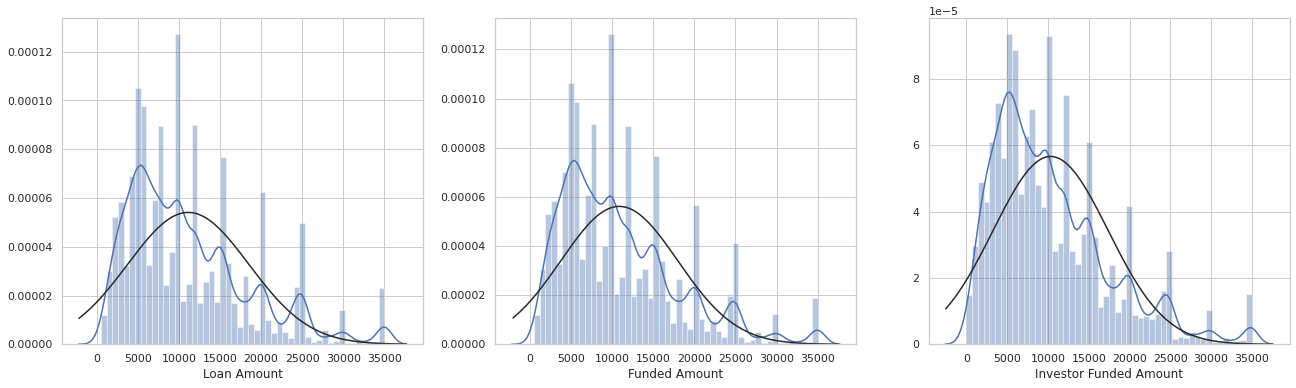

In [229]:
plt.subplots(figsize=(22,6)) 
plt.subplot(1,3,1)
sns.distplot(loans.loan_amnt,fit = norm)
plt.xlabel('Loan Amount')
plt.subplot(1,3,2)
sns.distplot(loans.funded_amnt,fit = norm )
plt.xlabel('Funded Amount')
plt.subplot(1,3,3)
sns.distplot(loans.funded_amnt_inv,fit = norm)
plt.xlabel('Investor Funded Amount')
plt.show()

In [230]:
loans =  loans[loans['loan_status'].isin(['Fully Paid','Charged Off'])]

### Loan Status

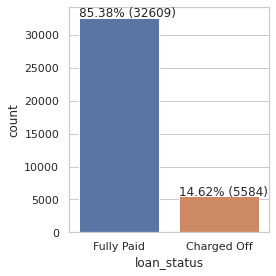

In [231]:
plot_count_chart(loans.loan_status, (4,4))

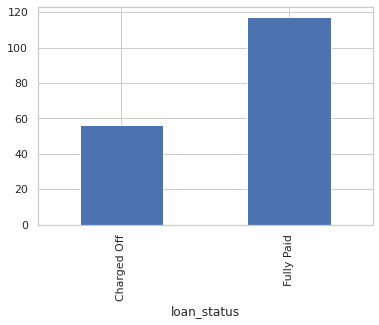

In [232]:
#plot_count_chart((loans.groupby('loan_status').total_pymnt.sum() * 100 / loans.groupby('loan_status').loan_amnt.sum()), (4,4))

(loans.groupby('loan_status').total_pymnt.sum() * 100 / loans.groupby('loan_status').loan_amnt.sum()).plot.bar()
plt.xlabel('loan_status')
plt.show()


It can be observed that around 14.20% of loans are charged off<br>
Lending Club only recovers ~60% of the loan amount when loans are charged off. On fully paid up loans, the company makes ~20% profit.

### home_ownership

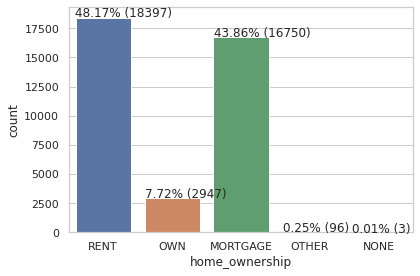

In [233]:
plot_count_chart(loans.home_ownership, (6,4))

### purpose of loan

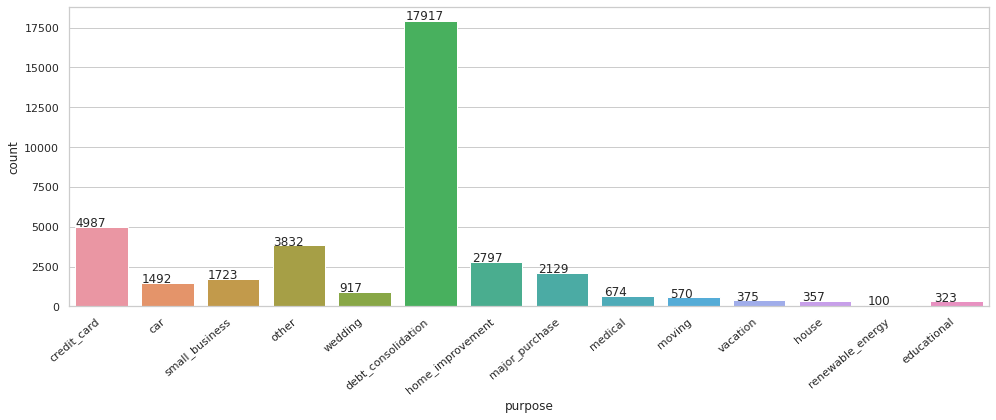

In [234]:
plot_count_chart(loans.purpose, (14,6), isPercentage=False)

It can be observed that around 47% of the loans are taken for debt consolidation and the next highest being around ~13% is for credit card payments. So majorly loans are taken for existing debt's

TOP 5 Employee

In [235]:
top5 = loans.emp_title.value_counts(normalize=False).head(10)
top5

Not Given            2345
US Army              131 
Bank of America      107 
IBM                  62  
AT&T                 57  
Kaiser Permanente    56  
UPS                  52  
Wells Fargo          52  
USAF                 52  
US Air Force         51  
Name: emp_title, dtype: int64

### verification status

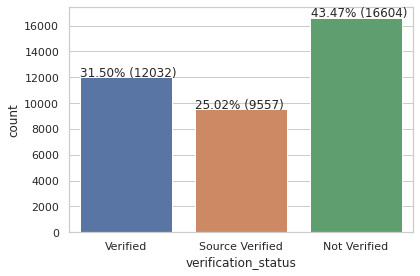

In [236]:
plot_count_chart(loans.verification_status, (6,4))

Around 42.81% of loans are not verified

### Term

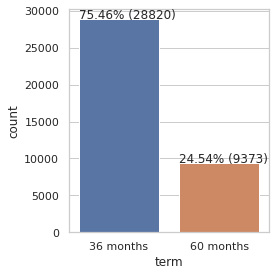

In [237]:
plot_count_chart(loans.term, (4,4))

Around 73.3% of the loans are for 36 months. i.e many people take short term loans compared to long term loans

### delinq_2yrs

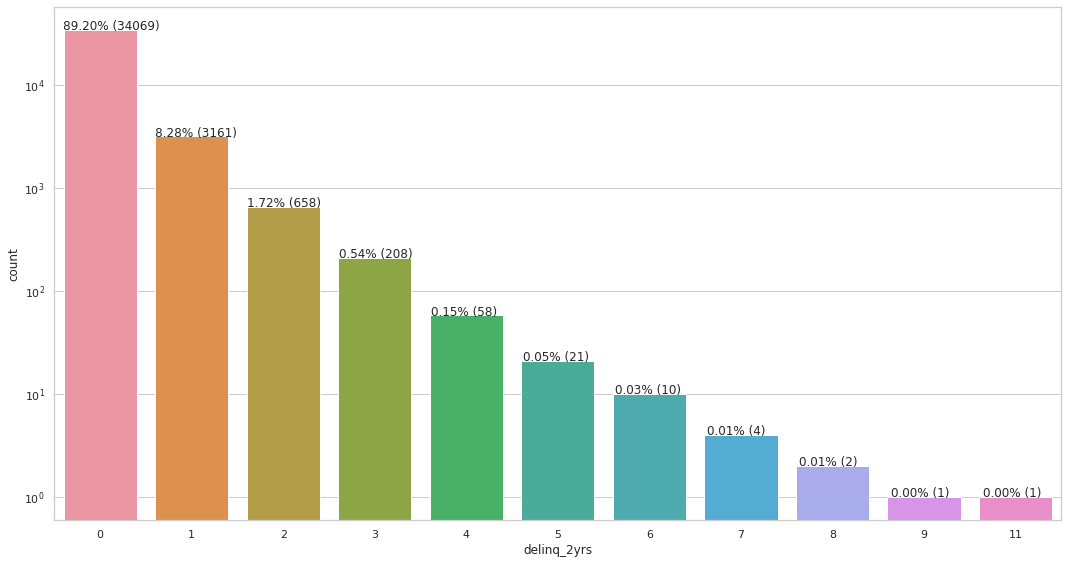

In [238]:
plot_count_chart(loans.delinq_2yrs, figsize=(15,8), logScale=True)

People tend to have lesser number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

### Numbers of years of Experience

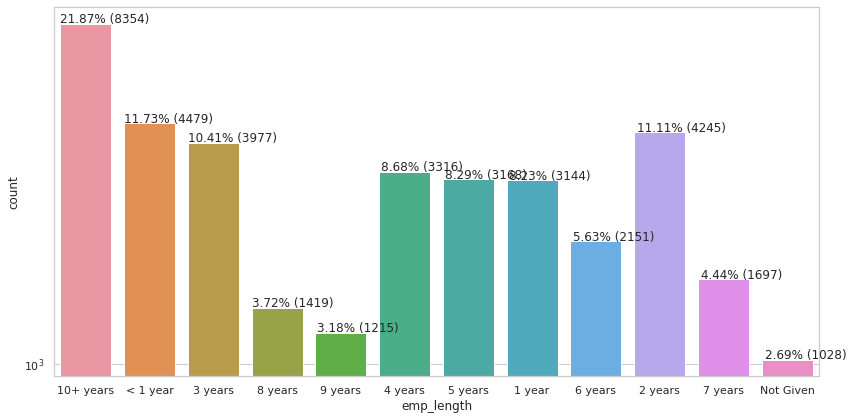

In [239]:
plot_count_chart(loans.emp_length, logScale=True, figsize=(12,6))

People with 10+ years of experience take more loans.
The observation can be broken into 2 chunks, people with less than 4 years of experience and 10+ years of experience take more loans

### Grades of loan

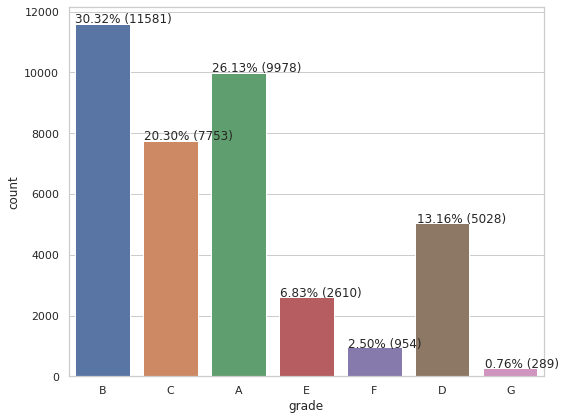

In [240]:
plot_count_chart(loans.grade, figsize=(8, 6))

There are more lower grade loans

### no of inquires in last 6 months

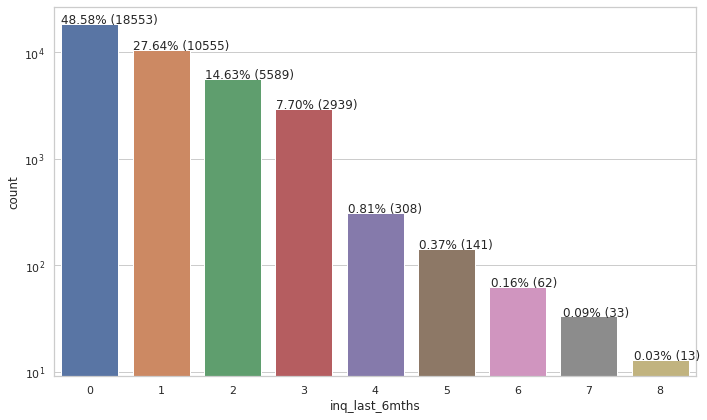

In [241]:
plot_count_chart(loans.inq_last_6mths, logScale=True, figsize=(10,6))

### Months since last delinquency

## SEGMENTED UNIVARIATE & BIVARIATE ANALYSIS

We have included bivariate analysis in between as it helped analyising data better.

###Region Analysis

In [242]:
pd.crosstab([loans.addr_state],loans.loan_status,values=loans.loan_amnt,aggfunc='count' ,normalize= 'index')

loan_status,Charged Off,Fully Paid
addr_state,,
AK,0.181818,0.818182
AL,0.125000,0.875000
AR,0.114894,0.885106
AZ,0.144219,0.855781
CA,0.162139,0.837861
CO,0.128307,0.871693
CT,0.132022,0.867978
DC,0.071090,0.928910
DE,0.106195,0.893805


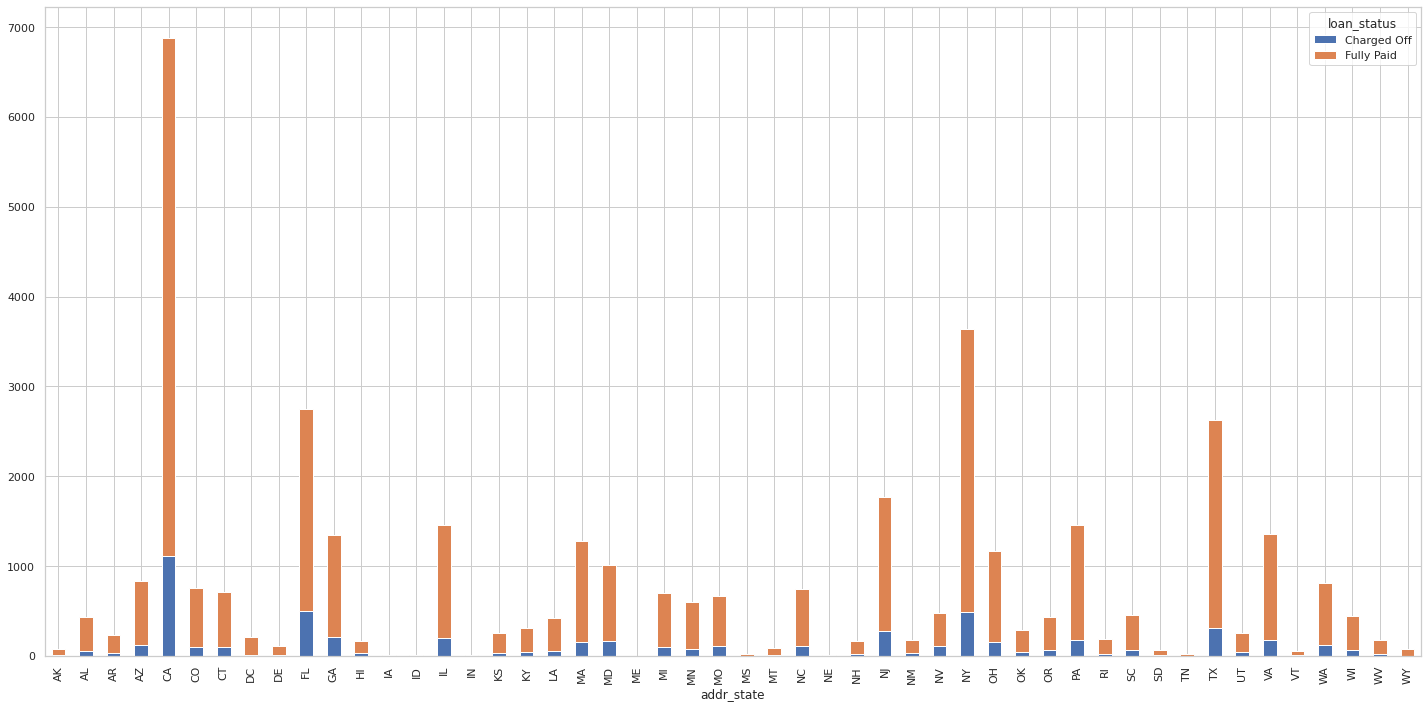

In [243]:
bar_plot('addr_state', 'loan_status' ,data=loans, axistoggle= 'on',tabletoggle= False,sizerow= 20)

In [244]:
#map states to regions
states = {
     'AK' :  'West' ,  'AL' :  'South' ,  'AR' :  'South' ,  'AZ' :  'West' ,  'CA' :  'West' ,  'CO' :  'West' ,  'CT' :  'Northeast' ,
       'DC' :  'South' ,  'DE' :  'South' ,  'FL' :  'South' ,  'GA' :  'South' ,  'HI' :  'West' ,  'IA' :  'Midwest' ,  'ID' :  'West' , 
        'IL' :  'Midwest' ,  'IN' :  'Midwest' ,  'KS' :  'Midwest' ,  'KY' :  'South' ,  'LA' :  'South' ,  'MA' :  'Northeast' ,  'MD' :  'South' , 
         'ME' :  'Northeast' ,  'MI' :  'Midwest' ,  'MN' :  'Midwest' ,  'MO' :  'Midwest' ,  'MS' :  'South' ,  'MT' :  'West' ,  'NC' :  'South' ,
          'ND' :  'Midwest' ,  'NE' :  'Midwest' ,  'NH' :  'Northeast' ,  'NJ' :  'Northeast' ,  'NM' :  'West' ,  'NV' :  'West' ,  'NY' :  'Northeast' , 
          'OH' :  'Midwest' ,  'OK' :  'South' ,  'OR' :  'West' ,  'PA' :  'Northeast' ,  'RI' :  'Northeast' ,  'SC' :  'South' ,  'SD' :  'Midwest' , 
          'TN' :  'South' ,  'TX' :  'South' ,  'UT' :  'West' ,  'VA' :  'South' ,  'VT' :  'Northeast' ,  'WA' :  'West' ,  'WI' :  'Midwest' , 
          'WV' :  'South' ,  'WY' :  'West' 
}
loans['Region']= loans['addr_state'].map(states)


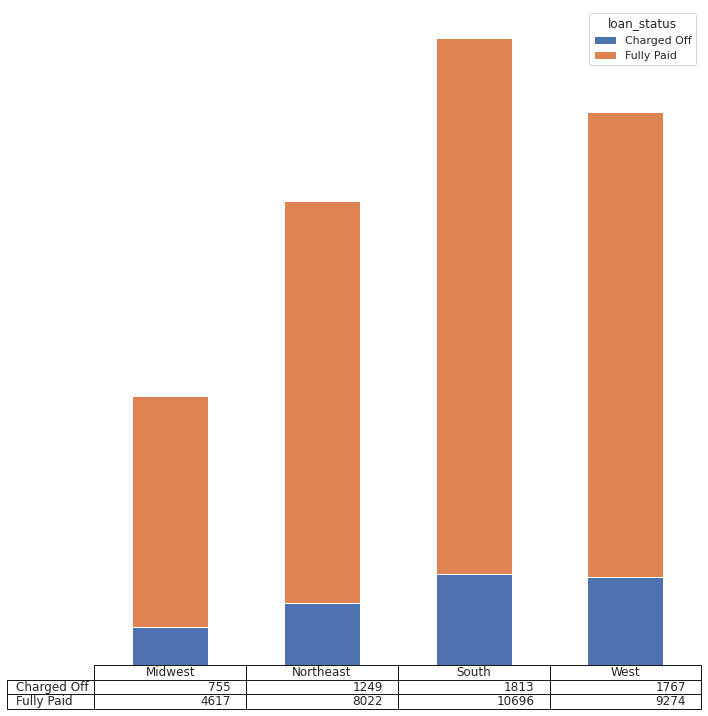

In [245]:
bar_plot('Region' , 'loan_status', data=loans)


In [246]:
pd.crosstab([loans.Region],loans.loan_status,values=loans.loan_amnt,aggfunc='count' ,normalize= 'index')

loan_status,Charged Off,Fully Paid
Region,,
Midwest,0.140544,0.859456
Northeast,0.134721,0.865279
South,0.144936,0.855064
West,0.160040,0.839960


Now let us look at multiple factors with respect to loan status

### Verification Status vs Loan Status

In [247]:
pd.crosstab(index=  [loans.verification_status],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
verification_status,,
Not Verified,0.128282,0.871718
Source Verified,0.148791,0.851209
Verified,0.168883,0.831117


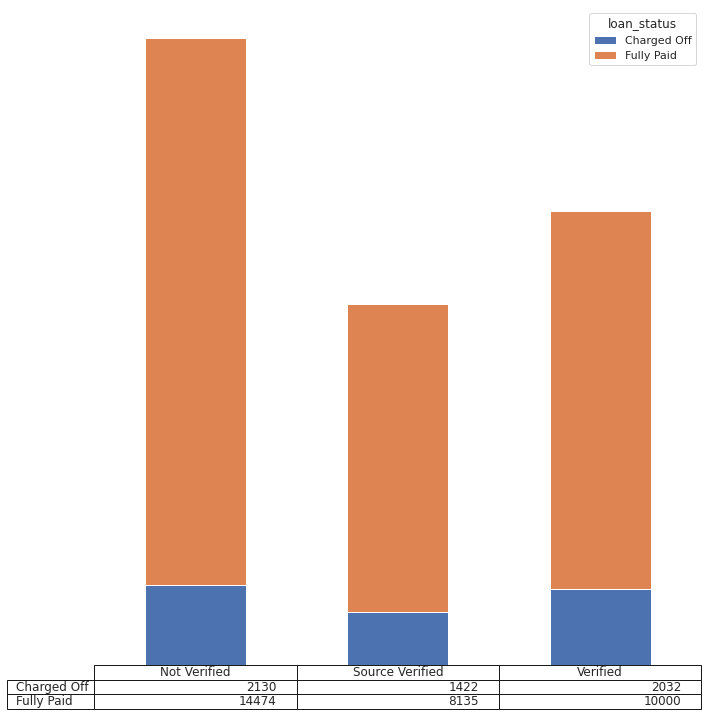

In [248]:
bar_plot('verification_status' ,'loan_status', data=loans)

People who has verification status as verified are the ones with highest chances to be charged off

### Employment Length vs Loan Status

In [249]:
pd.crosstab(index=  [loans.emp_length],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
emp_length,,
1 year,0.144720,0.855280
10+ years,0.157529,0.842471
2 years,0.132155,0.867845
3 years,0.138547,0.861453
4 years,0.137515,0.862485
5 years,0.143939,0.856061
6 years,0.141795,0.858205
7 years,0.154390,0.845610
8 years,0.143058,0.856942


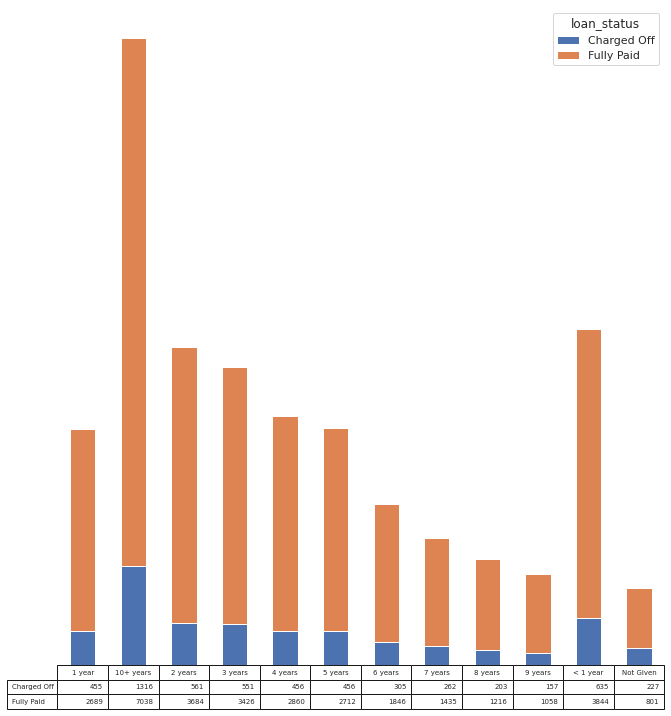

In [250]:
bar_plot('emp_length' ,'loan_status', data=loans)

People who do not specify employment length have atleast 6% higher chances of not paying loan

### Grade vs Loan Status

In [251]:
pd.crosstab(index=  [loans.grade],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
grade,,
A,0.060233,0.939767
B,0.122097,0.877903
C,0.173094,0.826906
D,0.221161,0.778839
E,0.269732,0.730268
F,0.327044,0.672956
G,0.342561,0.657439


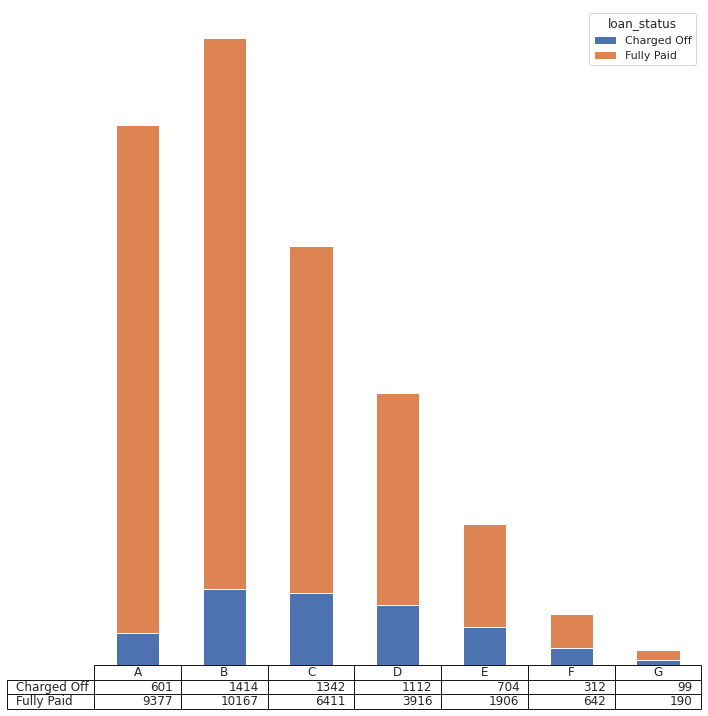

In [252]:
bar_plot('grade','loan_status', data = loans)

In [253]:
pd.crosstab(index=  [loans.sub_grade],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
sub_grade,,
A1,0.026502,0.973498
A2,0.049366,0.950634
A3,0.057254,0.942746
A4,0.062369,0.937631
A5,0.080178,0.919822
B1,0.095185,0.904815
B2,0.113751,0.886249
B3,0.119986,0.880014
B4,0.135258,0.864742


As the grade increases, chances of loan being charged off increases, same is observed with sub grade

### Home Ownership vs Loan Status

In [254]:
pd.crosstab(index=  [loans.home_ownership],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
home_ownership,,
MORTGAGE,0.137433,0.862567
NONE,0.000000,1.000000
OTHER,0.187500,0.812500
OWN,0.149304,0.850696
RENT,0.153503,0.846497


People whoes home ownership status is other has higher chances of being charged off

### Loan Purpose vs Loan Status

In [255]:
pd.crosstab(index=  [loans.purpose],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
purpose,,
car,0.107239,0.892761
credit_card,0.107680,0.892320
debt_consolidation,0.153597,0.846403
educational,0.170279,0.829721
home_improvement,0.120844,0.879156
house,0.162465,0.837535
major_purchase,0.103335,0.896665
medical,0.157270,0.842730
moving,0.159649,0.840351


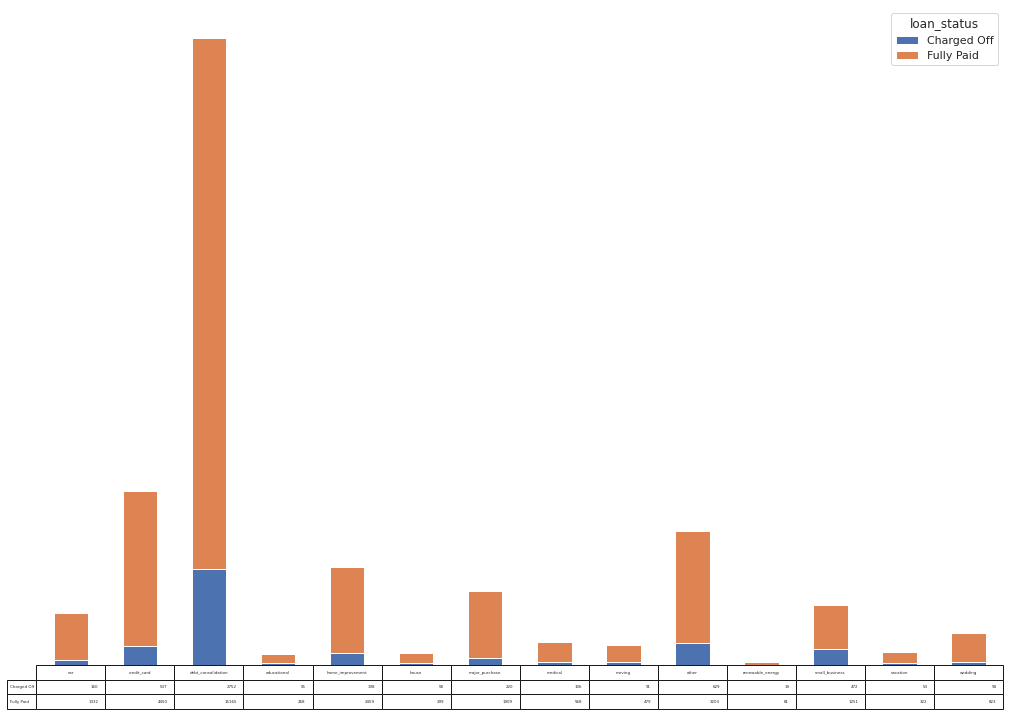

In [256]:
bar_plot('purpose','loan_status', data = loans, sizerow=15, sizecolumn=10)

Loan's given to small business has around 26% chances of being charged off

### No Of Inquiry vs Loan Status

In [257]:
pd.crosstab(index=  [loans.inq_last_6mths],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
inq_last_6mths,,
0,0.121867,0.878133
1,0.157461,0.842539
2,0.168188,0.831812
3,0.208915,0.791085
4,0.165584,0.834416
5,0.191489,0.808511
6,0.258065,0.741935
7,0.303030,0.696970
8,0.230769,0.769231


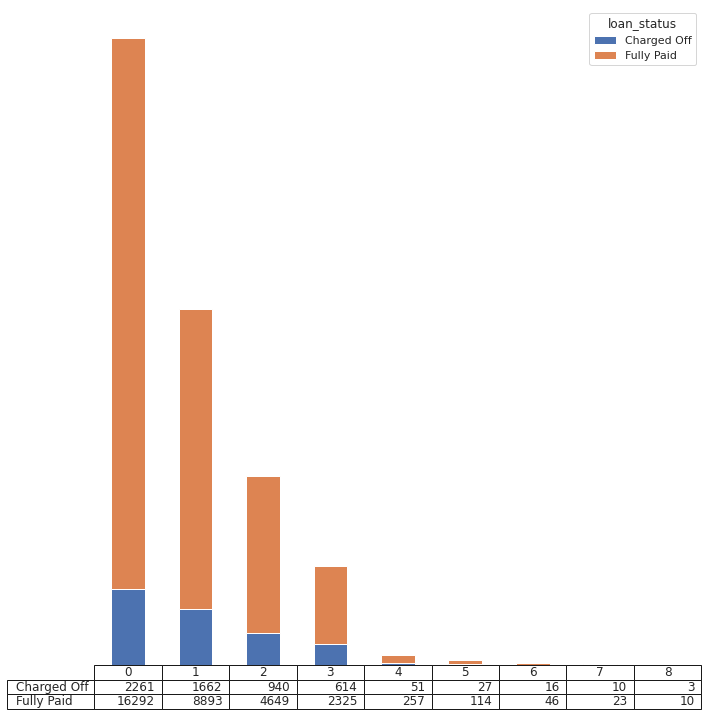

In [258]:
bar_plot('inq_last_6mths','loan_status', data = loans)

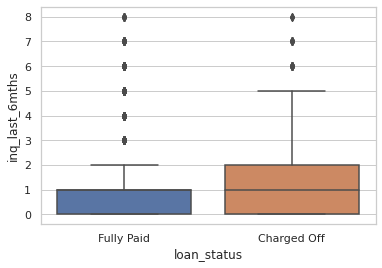

In [259]:
sns.set(style="whitegrid")
sns.boxplot(y=loans.inq_last_6mths , x= loans.loan_status) 

People with number of inquiry greater than 4 will have more chances of loan being charged off, highest being at 7

### Derogatory public record vs Loan Status

In [260]:
pd.crosstab(index=  [loans.pub_rec],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
pub_rec,,
0,0.141703,0.858297
1,0.226434,0.773566
2,0.212766,0.787234
3,0.000000,1.000000
4,0.000000,1.000000


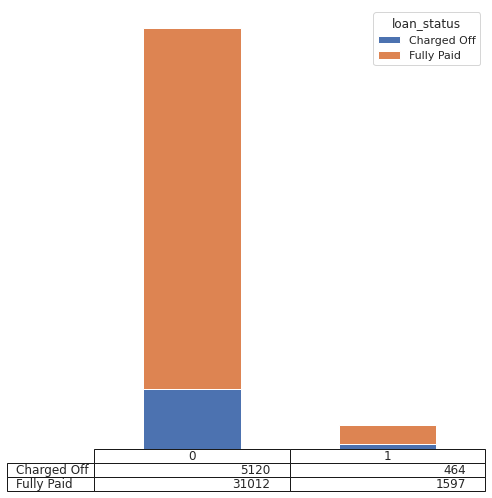

In [261]:
loans['pub_rec_exists']= loans.pub_rec.apply(lambda x: 1 if x>0 else 0)
bar_plot('pub_rec_exists' , 'loan_status',sizerow=7 , sizecolumn=7,data = loans)

People with more than one derogatory public record have more than 20% chances of loan being charged off

### Public record bankruptcies vs Loan Status

In [262]:
pd.crosstab(index=  [loans.pub_rec_bankruptcies],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
pub_rec_bankruptcies,,
-1.0,0.168605,0.831395
0.0,0.142220,0.857780
1.0,0.223515,0.776485
2.0,0.400000,0.600000


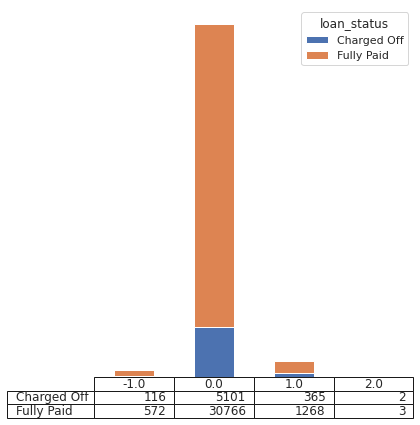

In [263]:
bar_plot('pub_rec_bankruptcies' , 'loan_status',sizerow=6 , sizecolumn=6,data = loans)

People with atleast 1 public record bankruptcies have more than 20 % chances of loan being charged off <br>
"-1" indicates invalid values

### Interest Rate vs Loan Status

We will bucketize the interest rates first and then do the analysis

In [264]:
loans['interest_bin'] = pd.qcut(loans.int_rate, 4, labels=['<0.09' , '<.12' , '<.15' , '<.25'],duplicates = 'drop')

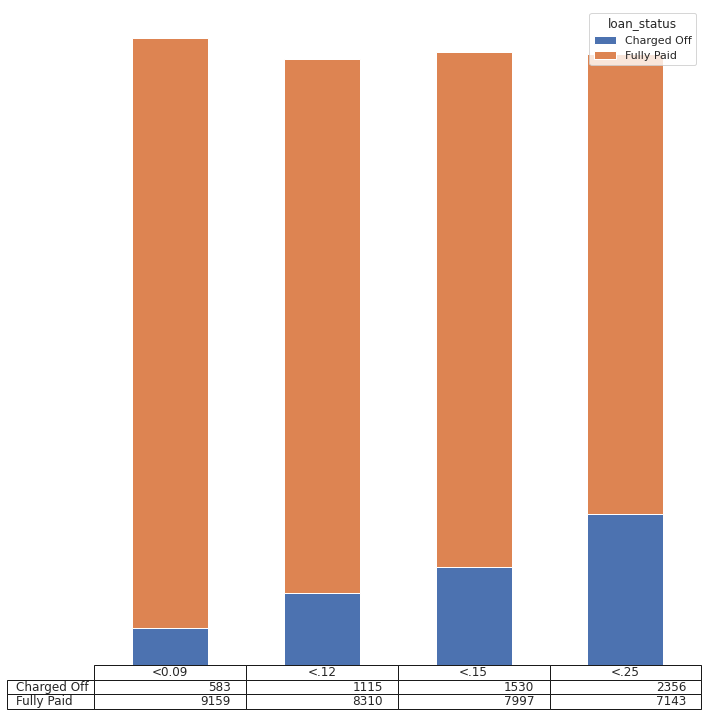

In [265]:
bar_plot('interest_bin' ,'loan_status', data = loans)

In [266]:
pd.crosstab([loans.interest_bin],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Fully Paid
interest_bin,,
<0.09,0.059844,0.940156
<.12,0.118302,0.881698
<.15,0.160596,0.839404
<.25,0.248026,0.751974


Higher the Interest rate, higher the chances of loan being charged off

### Loan Amount vs Loan Status

In [267]:
loans.loan_amnt.describe()

count    38193.000000
mean     10962.411960
std      7266.136171 
min      500.000000  
25%      5200.000000 
50%      9600.000000 
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

In [268]:
pd.crosstab(index=  [pd.cut(loans.loan_amnt, np.arange(0, np.floor(loans.loan_amnt.max()+5000), 5000),include_lowest=True)],
            columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
loan_amnt,,
"(-0.001, 5000.0]",0.138830,0.861170
"(5000.0, 10000.0]",0.128513,0.871487
"(10000.0, 15000.0]",0.137615,0.862385
"(15000.0, 20000.0]",0.173072,0.826928
"(20000.0, 25000.0]",0.192517,0.807483
"(25000.0, 30000.0]",0.210134,0.789866
"(30000.0, 35000.0]",0.257440,0.742560


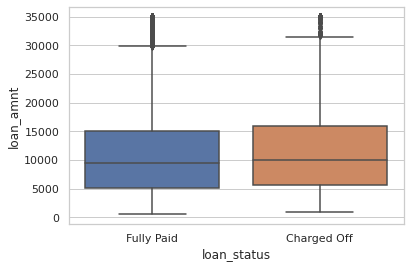

In [269]:
sns.boxplot(y=loans.loan_amnt , x= loans.loan_status)

Higher the loan amount, higher the chances of loan being charged off

### Annual Income vs Loan Status

In [270]:
loans.annual_inc.describe()

count    38193.000000 
mean     65322.485244 
std      35171.242586 
min      4000.000000  
25%      40000.000000 
50%      58000.000000 
75%      80263.000000 
max      234996.000000
Name: annual_inc, dtype: float64

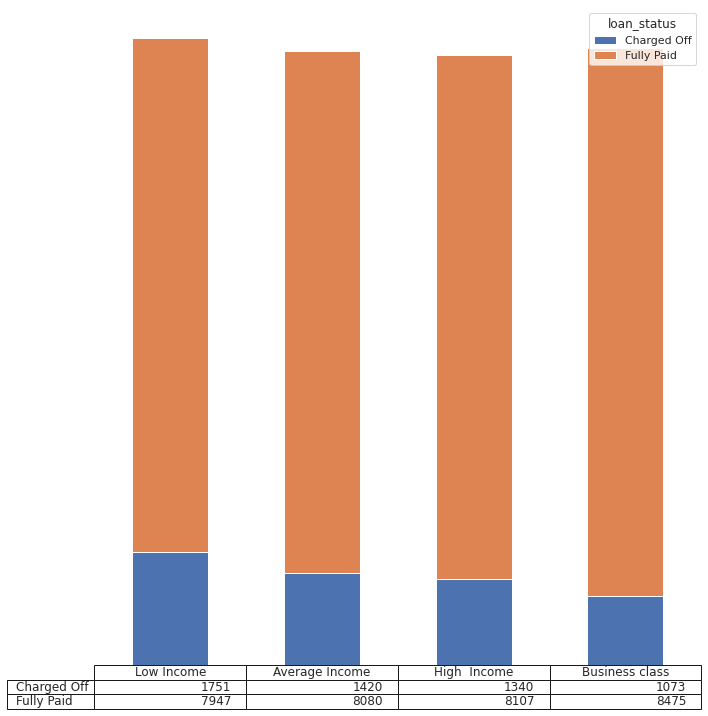

In [271]:
loans['annual_inc_bin'] = pd.qcut(loans.annual_inc, 4, labels=['Low Income','Average Income','High  Income' ,'Business class'],duplicates = 'drop')
bar_plot(x='annual_inc_bin',y='loan_status' ,data = loans)

In [272]:
pd.crosstab(index=  [loans.annual_inc_bin],
          columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count', normalize='index' )

loan_status,Charged Off,Fully Paid
annual_inc_bin,,
Low Income,0.180553,0.819447
Average Income,0.149474,0.850526
High Income,0.141844,0.858156
Business class,0.112380,0.887620


lower the annual income, higher the chances of loan being charged off.

### dti vs Loan Status

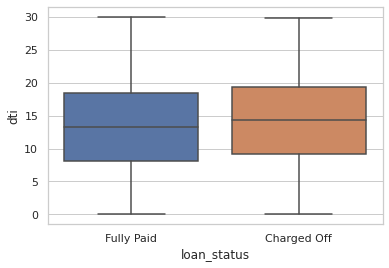

In [273]:
sns.boxplot(y=loans.dti , x= loans.loan_status) 

In [274]:
loans['dti_bin'] = pd.qcut(loans.dti, 4, labels=False,duplicates = 'drop')
pd.crosstab([loans.dti_bin],loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Fully Paid
dti_bin,,
0,0.124660,0.875340
1,0.138263,0.861737
2,0.154353,0.845647
3,0.167576,0.832424


dti seems to not have any impact on loan status

### CHECK ON FICO SCORE 

In [275]:
loans['fico']=loans.desc.apply(lambda x : 1 if re.search('fico' ,x ) else 0 )

In [276]:
pd.crosstab([loans.fico  ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Fully Paid
fico,,
0,0.146061,0.853939
1,0.375000,0.625000


In [277]:
loans_fico =loans[loans.fico == 1]
pd.crosstab([loans_fico.purpose  ],loans_fico.loan_status,values=loans_fico.loan_amnt,aggfunc='count',
           normalize='columns')

loan_status,Charged Off,Fully Paid
purpose,,
car,0.111111,0.000000
credit_card,0.111111,0.066667
debt_consolidation,0.666667,0.533333
house,0.000000,0.066667
major_purchase,0.000000,0.066667
other,0.111111,0.133333
small_business,0.000000,0.133333


Higher chances of loan getting charged off if fico is mentioned on desc<br>
The cases where charged off is higher are mostly(~88%) debt consolidation/other when Fico is mentioned.

###INSTALLMENT TO *INCOME* RATIO ANALYSIS

In [363]:
loans['installment_ratio'] = (loans.installment *100)/(loans.annual_inc/12)

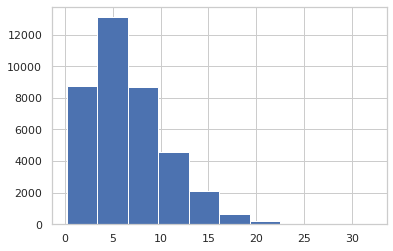

In [364]:
loans.installment_ratio.hist()

In [377]:
loans['high_installment_ratio'] = loans['installment_ratio'].apply(lambda x : 1 if x>8.9 else 0)


In [378]:
pd.crosstab([loans.high_installment_ratio  ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Fully Paid
high_installment_ratio,,
0,0.131457,0.868543
1,0.191086,0.808914


## DATA STORY 

WITH OUR UNDERSTANDING OF DATA , WE CAN NOW VENTURE INTO BUILDING STORY OR CONCLUDING OUR ANALYSIS 

In [341]:
rs = np.random.RandomState(0)
cor = loans[['annual_inc','collection_recovery_fee','dti','inq_last_6mths','installment','last_pymnt_amnt','loan_amnt','open_acc','pub_rec','pub_rec_bankruptcies','revol_bal','revol_util','total_acc','total_pymnt','total_pymnt_inv','total_rec_int','total_rec_late_fee','total_rec_prncp']].corr()
cor.style.background_gradient(cmap='coolwarm')

,annual_inc,collection_recovery_fee,dti,inq_last_6mths,installment,last_pymnt_amnt,loan_amnt,open_acc,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp
annual_inc,1.000000,0.022723,-0.107875,0.038202,0.412153,0.223935,0.414847,0.262339,-0.020332,-0.008268,0.423752,0.040895,0.378811,0.394815,0.379875,0.282647,0.014766,0.395692
collection_recovery_fee,0.022723,1.000000,0.012845,0.013090,0.077061,-0.043164,0.076619,0.005647,-0.005464,-0.009831,0.023965,0.027338,0.009574,0.027729,0.018302,0.041470,0.092085,-0.059169
dti,-0.107875,0.012845,1.000000,0.004997,0.061632,0.014186,0.071841,0.292404,-0.005540,0.031539,0.242872,0.280294,0.236049,0.068437,0.075107,0.110364,-0.010777,0.045744
inq_last_6mths,0.038202,0.013090,0.004997,1.000000,0.007608,0.026334,0.009577,0.092627,0.024718,0.004176,-0.022326,-0.069106,0.111523,-0.011654,-0.021884,0.024517,0.030649,-0.024983
installment,0.412153,0.077061,0.061632,0.007608,1.000000,0.411857,0.931735,0.169552,-0.044427,-0.025883,0.303173,0.096008,0.223629,0.856987,0.815769,0.642021,0.059463,0.845497
last_pymnt_amnt,0.223935,-0.043164,0.014186,0.026334,0.411857,1.000000,0.473052,0.081230,-0.032308,0.001208,0.120527,-0.014702,0.165391,0.511364,0.500043,0.241248,-0.061713,0.567451
loan_amnt,0.414847,0.076619,0.071841,0.009577,0.931735,0.473052,1.000000,0.174342,-0.048784,-0.016656,0.308918,0.065836,0.250876,0.880491,0.845922,0.728121,0.048269,0.843581
open_acc,0.262339,0.005647,0.292404,0.092627,0.169552,0.081230,0.174342,1.000000,0.000876,0.003342,0.288474,-0.088308,0.686514,0.159279,0.149271,0.120359,-0.018179,0.157448
pub_rec,-0.020332,-0.005464,-0.005540,0.024718,-0.044427,-0.032308,-0.048784,0.000876,1.000000,0.704169,-0.060012,0.059955,-0.022234,-0.051713,-0.052154,-0.002855,-0.002084,-0.063405
pub_rec_bankruptcies,-0.008268,-0.009831,0.031539,0.004176,-0.025883,0.001208,-0.016656,0.003342,0.704169,1.000000,-0.039648,0.067519,0.011082,-0.019591,0.040181,0.020750,-0.026352,-0.031144


###Public Records/Bankrupcies/Interest/Late fee

LETS CHECK HOW A BALCKMARK ON OUR CUSTOMERS , INFLUENCE THEIR LOAN STATUS

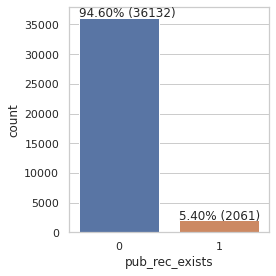

In [279]:
plot_count_chart(loans.pub_rec_exists, (4,4))

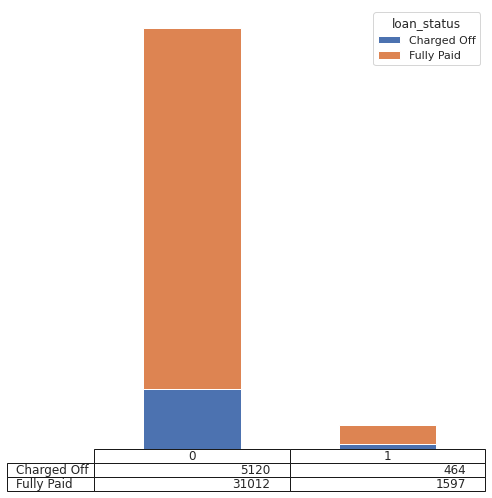

In [280]:
loans['pub_rec_exists']= loans.pub_rec.apply(lambda x: 1 if x>0 else 0)
bar_plot('pub_rec_exists' , 'loan_status', data=loans, sizerow=7 , sizecolumn=7)

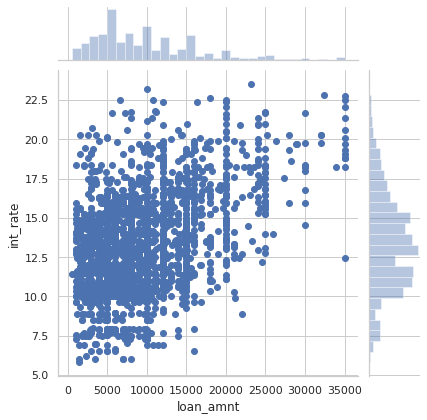

In [281]:
sns.jointplot('loan_amnt', 'int_rate', loans.loc[loans.pub_rec_exists > 0])

In [282]:
pd.crosstab([loans.pub_rec_exists],loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Fully Paid
pub_rec_exists,,
0,0.141703,0.858297
1,0.225133,0.774867


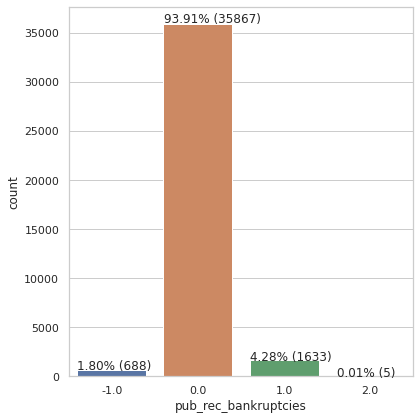

In [283]:
plot_count_chart(loans.pub_rec_bankruptcies, (6,6))

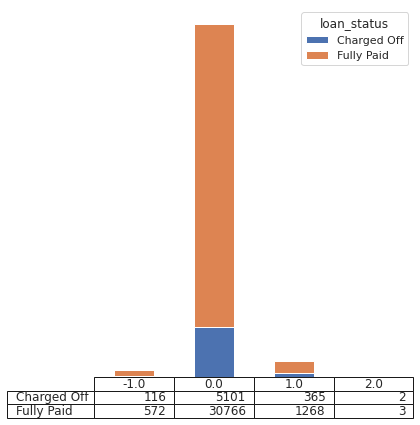

In [284]:
bar_plot('pub_rec_bankruptcies' , 'loan_status',data=loans, sizerow=6 , sizecolumn=6)

In [285]:
pd.crosstab([loans.pub_rec_bankruptcies ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Fully Paid
pub_rec_bankruptcies,,
-1.0,0.168605,0.831395
0.0,0.142220,0.857780
1.0,0.223515,0.776485
2.0,0.400000,0.600000


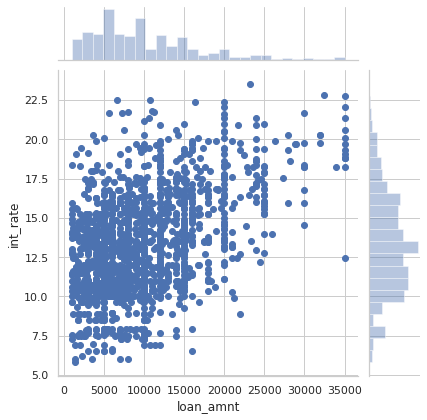

In [286]:
sns.jointplot('loan_amnt', 'int_rate', loans.loc[loans.pub_rec_bankruptcies > 0])

In [287]:
pd.crosstab([loans.pub_rec_bankruptcies ,loans.pub_rec_exists ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                          Charged Off  Fully Paid
pub_rec_bankruptcies pub_rec_exists                         
-1.0                 0               0.164671     0.835329  
                     1               0.300000     0.700000  
 0.0                 0               0.141270     0.858730  
                     1               0.225806     0.774194  
 1.0                 1               0.223515     0.776485  
 2.0                 1               0.400000     0.600000

In [288]:
pd.crosstab([loans.pub_rec_bankruptcies ,loans.pub_rec_exists ,
             loans.interest_bin],loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                                       Charged Off  Fully Paid
pub_rec_bankruptcies pub_rec_exists interest_bin                         
-1.0                 0              <0.09         0.038961     0.961039  
                                    <.12          0.157407     0.842593  
                                    <.15          0.272152     0.727848  
                                    <.25          0.312500     0.687500  
                     1              <.12          0.250000     0.750000  
                                    <.15          0.428571     0.571429  
                                    <.25          0.000000     1.000000  
 0.0                 0              <0.09         0.059739     0.940261  
                                    <.12          0.115613     0.884387  
                                    <.15          0.154888     0.845112  
                                    <.25          0.241225     0.758775  
                     1              <0.09         0.100000     0.900000  
                                    <.12          0.141026     0.858974  
                                    <.15          0.258993     0.741007  
                                    <.25          0.253012     0.746988  
 1.0                 1              <0.09         0.086614     0.913386  
                                    <.12          0.133017     0.866983  
                                    <.15          0.193676     0.806324  
                                    <.25          0.345423     0.654577  
 2.0                 1              <.12          1.000000     0.000000  
                                    <.15          0.000000     1.000000  
                                    <.25          0.333333     0.666667

The chances of loan charge off is higher if banrupsies are present , even where no bankrupsy , any public record will increase chances of loan getting wrtten off

In [289]:
loans.total_rec_late_fee.describe()

count    38193.000000
mean     1.366694    
std      7.308935    
min      0.000000    
25%      0.000000    
50%      0.000000    
75%      0.000000    
max      180.200000  
Name: total_rec_late_fee, dtype: float64

In [290]:
loans['late_fee_status'] = loans.total_rec_late_fee.apply(lambda c : 'Yes' if c>1 else 'No')

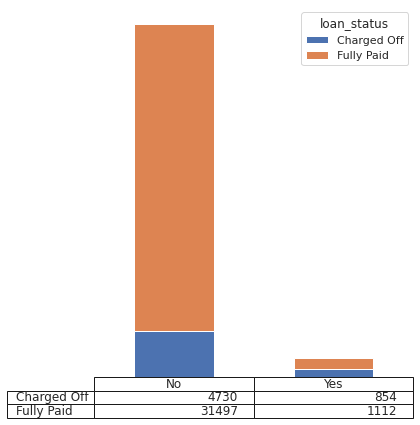

In [291]:
bar_plot('late_fee_status' , 'loan_status', data=loans, sizerow=6 , sizecolumn=6)

In [292]:
pd.crosstab([loans.late_fee_status ],loans.loan_status,
            values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Fully Paid
late_fee_status,,
No,0.130566,0.869434
Yes,0.434385,0.565615


In [293]:
pd.crosstab([loans.late_fee_status,loans.pub_rec_bankruptcies ,loans.pub_rec_exists ,
             loans.interest_bin],loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                                                       Charged Off  \
late_fee_status pub_rec_bankruptcies pub_rec_exists interest_bin                
No              -1.0                 0              <0.09         0.027027      
                                                    <.12          0.135417      
                                                    <.15          0.242857      
                                                    <.25          0.250000      
                                     1              <.12          0.111111      
                                                    <.15          0.500000      
                                                    <.25          0.000000      
                 0.0                 0              <0.09         0.052734      
                                                    <.12          0.105289      
                                                    <.15          0.137586      
                                                    <.25          0.218404      
                                     1              <0.09         0.100000      
                                                    <.12          0.135135      
                                                    <.15          0.236641      
                                                    <.25          0.236842      
                 1.0                 1              <0.09         0.080645      
                                                    <.12          0.121287      
                                                    <.15          0.181628      
                                                    <.25          0.332721      
                 2.0                 1              <.12          1.000000      
                                                    <.15          0.000000      
                                                    <.25          0.500000      
Yes             -1.0                 0              <0.09         0.333333      
                                                    <.12          0.333333      
                                                    <.15          0.500000      
                                                    <.25          0.750000      
                                     1              <.12          0.666667      
                                                    <.15          0.000000      
                 0.0                 0              <0.09         0.346667      
                                                    <.12          0.362319      
                                                    <.15          0.421053      
                                                    <.25          0.508006      
                                     1              <.12          0.250000      
                                                    <.15          0.625000      
                                                    <.25          0.428571      
                 1.0                 1              <0.09         0.333333      
                                                    <.12          0.411765      
                                                    <.15          0.407407      
                                                    <.25          0.542857      
                 2.0                 1              <.25          0.000000      

loan_status                                                       Fully Paid  
late_fee_status pub_rec_bankruptcies pub_rec_exists interest_bin              
No              -1.0                 0              <0.09         0.972973    
                                                    <.12          0.864583    
                                                    <.15          0.757143    
                                                    <.25          0.750000    
                                     1              <.12          0.888889    
                                            

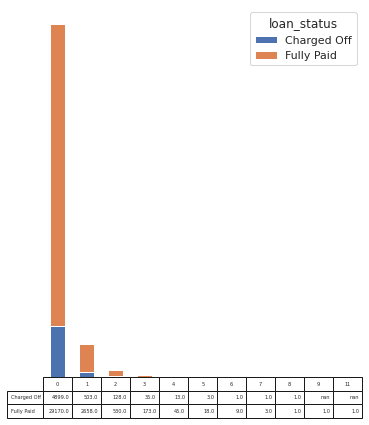

In [294]:
bar_plot('delinq_2yrs' , 'loan_status',data=loans, sizerow=6 , sizecolumn=6)

In [295]:
loans['delinq_status'] = loans.delinq_2yrs.apply(lambda c : 'Yes' if c>1 else 'No')

In [296]:
pd.crosstab([loans.delinq_status, loans.late_fee_status],
            loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                    Charged Off  Fully Paid
delinq_status late_fee_status                         
No            No               0.129809     0.870191  
              Yes              0.432907     0.567093  
Yes           No               0.161143     0.838857  
              Yes              0.465909     0.534091

In [297]:
pd.crosstab([loans.delinq_status, loans.late_fee_status,
             loans.pub_rec_bankruptcies ,loans.pub_rec_exists ],
            loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                                                        Charged Off  \
delinq_status late_fee_status pub_rec_bankruptcies pub_rec_exists                
No            No              -1.0                 0               0.134251      
                                                   1               0.266667      
                               0.0                 0               0.124996      
                                                   1               0.207084      
                               1.0                 1               0.211640      
                               2.0                 1               0.500000      
              Yes             -1.0                 0               0.409836      
                                                   1               0.500000      
                               0.0                 0               0.432670      
                                                   1               0.461538      
                               1.0                 1               0.448718      
                               2.0                 1               0.000000      
Yes           No              -1.0                 0               0.260870      
                                                   1               0.000000      
                               0.0                 0               0.155860      
                                                   1               0.300000      
                               1.0                 1               0.179487      
              Yes             -1.0                 0               0.333333      
                               0.0                 0               0.456790      
                               1.0                 1               0.750000      

loan_status                                                        Fully Paid  
delinq_status late_fee_status pub_rec_bankruptcies pub_rec_exists              
No            No              -1.0                 0               0.865749    
                                                   1               0.733333    
                               0.0                 0               0.875004    
                                                   1               0.792916    
                               1.0                 1               0.788360    
                               2.0                 1               0.500000    
              Yes             -1.0                 0               0.590164    
                                                   1               0.500000    
                               0.0                 0               0.567330    
                                                   1               0.538462    
                               1.0                 1               0.551282    
                               2.0                 1               1.000000    
Yes           No              -1.0                 0               0.739130    
                                                   1               1.000000    
                               0.0                 0               0.844140    
                                                   1               0.700000    
                               1.0                 1               0.820513    
              Yes             -1.0                 0               0.666667    
                               0.0                 0               0.543210    
                               1.0                 1               0.250000

When there are 2 or more offence , its best to avoid giving loan 

###Revol Util/Income/Open acoount/Interest

LETS SEE IF THE LENDER CAN MAKE ANY CHANGES TO THE TYPE OF LAON GIVEN BASED ON CUSTOMERS EXISTING FINANCIAL HEALTH/STATUS.

In [298]:
loans.revol_util.describe()

count    38193.000000
mean     48.628884   
std      28.374226   
min     -1.000000    
25%      25.100000   
50%      49.000000   
75%      72.200000   
max      99.900000   
Name: revol_util, dtype: float64

In [299]:
loans['Revol_util_bin'] = pd.qcut(loans.revol_util, 4, labels=['Low util','Average util','High  Util' ,'Max Util'],duplicates = 'drop')

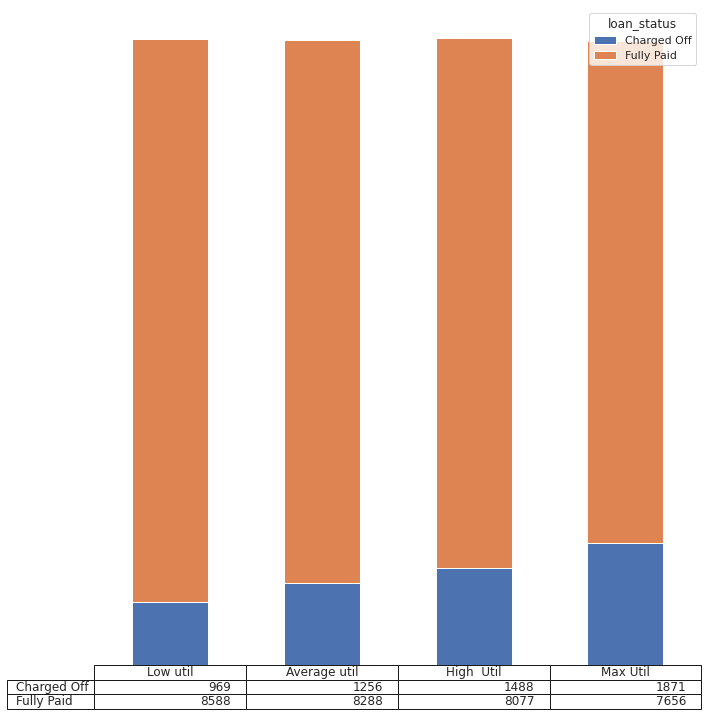

In [300]:
bar_plot('Revol_util_bin' ,'loan_status', data=loans )

In [301]:
loans.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'desc', 'purpose', 'title', 'zip_code', 'addr_state',
       'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'pub_rec_bankruptcies', 'Region',
       'pub_rec_exists', 'interest_bin', 'annual_inc_bin', 'dti_bin', 'fico',
       'late_fee_status', 'delinq_status', 'Revol_util_bin'],
      dtype='object')

In [302]:
pd.crosstab([loans.term,loans.interest_bin , loans.Revol_util_bin],loans.loan_status , 
            values= loans.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status                            Charged Off  Fully Paid
term      interest_bin Revol_util_bin                         
36 months <0.09        Low util        0.042979     0.957021  
                       Average util    0.060910     0.939090  
                       High  Util      0.085174     0.914826  
                       Max Util        0.092975     0.907025  
          <.12         Low util        0.093642     0.906358  
                       Average util    0.100360     0.899640  
                       High  Util      0.105978     0.894022  
                       Max Util        0.122097     0.877903  
          <.15         Low util        0.154390     0.845610  
                       Average util    0.134699     0.865301  
                       High  Util      0.127415     0.872585  
                       Max Util        0.144462     0.855538  
          <.25         Low util        0.215983     0.784017  
                       Average util    0.160828     0.839172  
                       High  Util      0.178145     0.821855  
                       Max Util        0.189504     0.810496  
60 months <0.09        Low util        0.074219     0.925781  
                       Average util    0.128000     0.872000  
                       High  Util      0.117647     0.882353  
                       Max Util        0.166667     0.833333  
          <.12         Low util        0.171852     0.828148  
                       Average util    0.172355     0.827645  
                       High  Util      0.180282     0.819718  
                       Max Util        0.218310     0.781690  
          <.15         Low util        0.195896     0.804104  
                       Average util    0.236802     0.763198  
                       High  Util      0.241641     0.758359  
                       Max Util        0.253731     0.746269  
          <.25         Low util        0.266234     0.733766  
                       Average util    0.295207     0.704793  
                       High  Util      0.289965     0.710035  
                       Max Util        0.331104     0.668896

In [303]:
loans['open_acc_bin'] = pd.qcut(loans.open_acc, 4, labels=['2-6','7-9','10-12','13-44'], duplicates='drop')
loans_60 = loans[(loans.term == '60 months') & (loans.interest_bin.isin(['<.15','<.25']))]
pd.crosstab([loans_60.interest_bin , loans_60.Revol_util_bin],
            loans_60.loan_status , values= loans_60.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status                  Charged Off  Fully Paid
interest_bin Revol_util_bin                         
<.15         Low util        0.195896     0.804104  
             Average util    0.236802     0.763198  
             High  Util      0.241641     0.758359  
             Max Util        0.253731     0.746269  
<.25         Low util        0.266234     0.733766  
             Average util    0.295207     0.704793  
             High  Util      0.289965     0.710035  
             Max Util        0.331104     0.668896

In [304]:
loans.emp_length.value_counts()

10+ years    8354
< 1 year     4479
2 years      4245
3 years      3977
4 years      3316
5 years      3168
1 year       3144
6 years      2151
7 years      1697
8 years      1419
9 years      1215
Not Given    1028
Name: emp_length, dtype: int64

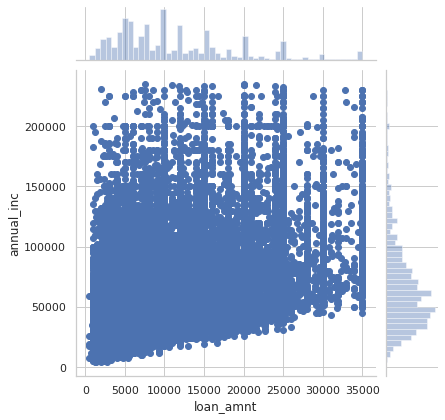

In [340]:
sns.jointplot('loan_amnt', 'annual_inc', loans)

In [305]:
pd.crosstab([loans_60.interest_bin , loans_60.Revol_util_bin, loans_60.annual_inc_bin],
            loans_60.loan_status , values= loans_60.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status                                 Charged Off  Fully Paid
interest_bin Revol_util_bin annual_inc_bin                         
<.15         Low util       Low Income      0.321101     0.678899  
                            Average Income  0.213740     0.786260  
                            High  Income    0.157534     0.842466  
                            Business class  0.126667     0.873333  
             Average util   Low Income      0.325926     0.674074  
                            Average Income  0.253165     0.746835  
                            High  Income    0.256983     0.743017  
                            Business class  0.141361     0.858639  
             High  Util     Low Income      0.389706     0.610294  
                            Average Income  0.220126     0.779874  
                            High  Income    0.243094     0.756906  
                            Business class  0.148352     0.851648  
             Max Util       Low Income      0.357143     0.642857  
                            Average Income  0.323810     0.676190  
                            High  Income    0.166667     0.833333  
                            Business class  0.212389     0.787611  
<.25         Low util       Low Income      0.371681     0.628319  
                            Average Income  0.226804     0.773196  
                            High  Income    0.284553     0.715447  
                            Business class  0.186047     0.813953  
             Average util   Low Income      0.309783     0.690217  
                            Average Income  0.287671     0.712329  
                            High  Income    0.383260     0.616740  
                            Business class  0.222222     0.777778  
             High  Util     Low Income      0.312757     0.687243  
                            Average Income  0.316940     0.683060  
                            High  Income    0.299492     0.700508  
                            Business class  0.246606     0.753394  
             Max Util       Low Income      0.423977     0.576023  
                            Average Income  0.345776     0.654224  
                            High  Income    0.345196     0.654804  
                            Business class  0.261765     0.738235

In [306]:
loans_60 = loans_60[loans_60.Revol_util_bin >'Average util']
loans_60.shape

(4598, 54)

In [307]:
pd.crosstab([loans_60.interest_bin , loans_60.Revol_util_bin,
             loans_60.annual_inc_bin],loans_60.loan_status , values= loans_60.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status                                 Charged Off  Fully Paid
interest_bin Revol_util_bin annual_inc_bin                         
<.15         High  Util     Low Income      0.389706     0.610294  
                            Average Income  0.220126     0.779874  
                            High  Income    0.243094     0.756906  
                            Business class  0.148352     0.851648  
             Max Util       Low Income      0.357143     0.642857  
                            Average Income  0.323810     0.676190  
                            High  Income    0.166667     0.833333  
                            Business class  0.212389     0.787611  
<.25         High  Util     Low Income      0.312757     0.687243  
                            Average Income  0.316940     0.683060  
                            High  Income    0.299492     0.700508  
                            Business class  0.246606     0.753394  
             Max Util       Low Income      0.423977     0.576023  
                            Average Income  0.345776     0.654224  
                            High  Income    0.345196     0.654804  
                            Business class  0.261765     0.738235

In [308]:
loans_60 = loans_60[loans_60.annual_inc_bin < 'High  Income']

In [309]:
pd.crosstab([loans_60.interest_bin , loans_60.Revol_util_bin,
             loans_60.annual_inc_bin],loans_60.loan_status , values= loans_60.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status                                 Charged Off  Fully Paid
interest_bin Revol_util_bin annual_inc_bin                         
<.15         High  Util     Low Income      0.389706     0.610294  
                            Average Income  0.220126     0.779874  
             Max Util       Low Income      0.357143     0.642857  
                            Average Income  0.323810     0.676190  
<.25         High  Util     Low Income      0.312757     0.687243  
                            Average Income  0.316940     0.683060  
             Max Util       Low Income      0.423977     0.576023  
                            Average Income  0.345776     0.654224

In [310]:
loans_60.open_acc_bin.unique()

[7-9, 13-44, 2-6, 10-12]
Categories (4, object): [2-6 < 7-9 < 10-12 < 13-44]

In [311]:
loans_60 = loans_60[loans_60.annual_inc_bin == 'Low Income']
pd.crosstab([loans_60.interest_bin , loans_60.Revol_util_bin,
             loans_60.annual_inc_bin,loans_60.open_acc_bin],loans_60.loan_status , values= loans_60.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status                                              Charged Off  \
interest_bin Revol_util_bin annual_inc_bin open_acc_bin                
<.15         High  Util     Low Income     2-6           0.333333      
                                           7-9           0.434783      
                                           10-12         0.526316      
                                           13-44         0.285714      
             Max Util       Low Income     2-6           0.350000      
                                           7-9           0.421053      
                                           10-12         0.125000      
                                           13-44         0.666667      
<.25         High  Util     Low Income     2-6           0.313131      
                                           7-9           0.280000      
                                           10-12         0.306122      
                                           13-44         0.450000      
             Max Util       Low Income     2-6           0.378109      
                                           7-9           0.431818      
                                           10-12         0.571429      
                                           13-44         0.611111      

loan_status                                              Fully Paid  
interest_bin Revol_util_bin annual_inc_bin open_acc_bin              
<.15         High  Util     Low Income     2-6           0.666667    
                                           7-9           0.565217    
                                           10-12         0.473684    
                                           13-44         0.714286    
             Max Util       Low Income     2-6           0.650000    
                                           7-9           0.578947    
                                           10-12         0.875000    
                                           13-44         0.333333    
<.25         High  Util     Low Income     2-6           0.686869    
                                           7-9           0.720000    
                                           10-12         0.693878    
                                           13-44         0.550000    
             Max Util       Low Income     2-6           0.621891    
                                           7-9           0.568182    
                                           10-12         0.428571    
                                           13-44         0.388889

###Income/Interest Rates/Employee length/Grade

Lets check how employess income influences the payment of loan taken.

In [399]:
 loans['loan_amnt_bin'] = pd.qcut(loans.loan_amnt, 4, labels=['<5200' , '<9600' , '<15000' , '<35000'],duplicates = 'drop')
 

In [400]:
pd.crosstab([loans.loan_amnt_bin ],loans.loan_status,
            values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Fully Paid
loan_amnt_bin,,
<5200,0.139231,0.860769
9600,0.126915,0.873085
<15000,0.136045,0.863955
<35000,0.189176,0.810824


In [401]:
pd.crosstab([loans.loan_amnt_bin ,loans.annual_inc_bin],loans.loan_status,
            values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                   Charged Off  Fully Paid
loan_amnt_bin annual_inc_bin                         
<5200         Low Income      0.163580     0.836420  
              Average Income  0.141646     0.858354  
              High  Income    0.117174     0.882826  
              Business class  0.077865     0.922135  
9600          Low Income      0.169967     0.830033  
              Average Income  0.117360     0.882640  
              High  Income    0.106289     0.893711  
              Business class  0.092669     0.907331  
<15000        Low Income      0.211911     0.788089  
              Average Income  0.136023     0.863977  
              High  Income    0.131086     0.868914  
              Business class  0.086972     0.913028  
<35000        Low Income      0.272109     0.727891  
              Average Income  0.241313     0.758687  
              High  Income    0.203505     0.796495  
              Business class  0.149627     0.850373

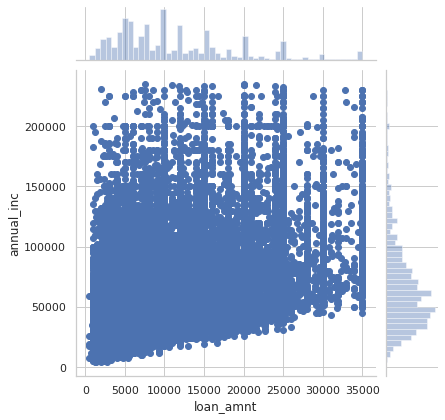

In [402]:
sns.jointplot('loan_amnt', 'annual_inc', loans)

In [403]:
pd.crosstab([loans.loan_amnt_bin ,loans.annual_inc_bin],loans.loan_status,
            values=loans.loan_amnt,aggfunc='count')

loan_status                   Charged Off  Fully Paid
loan_amnt_bin annual_inc_bin                         
<5200         Low Income      689          3523      
              Average Income  351          2127      
              High  Income    204          1537      
              Business class  89           1054      
9600          Low Income      515          2515      
              Average Income  313          2354      
              High  Income    240          2018      
              Business class  158          1547      
<15000        Low Income      427          1588      
              Average Income  381          2420      
              High  Income    385          2552      
              Business class  245          2572      
<35000        Low Income      120          321       
              Average Income  375          1179      
              High  Income    511          2000      
              Business class  581          3302

Binning Interest rates into quartiles

In [312]:
loans.int_rate.quantile([0.25,0.5,0.75,1])

0.25    8.94 
0.50    11.71
0.75    14.35
1.00    24.40
Name: int_rate, dtype: float64

In [313]:
loans['interest_bin'] = pd.qcut(loans.int_rate, 4, labels=['<0.09' , '<.12' , '<.15' , '<.25'],duplicates = 'drop')

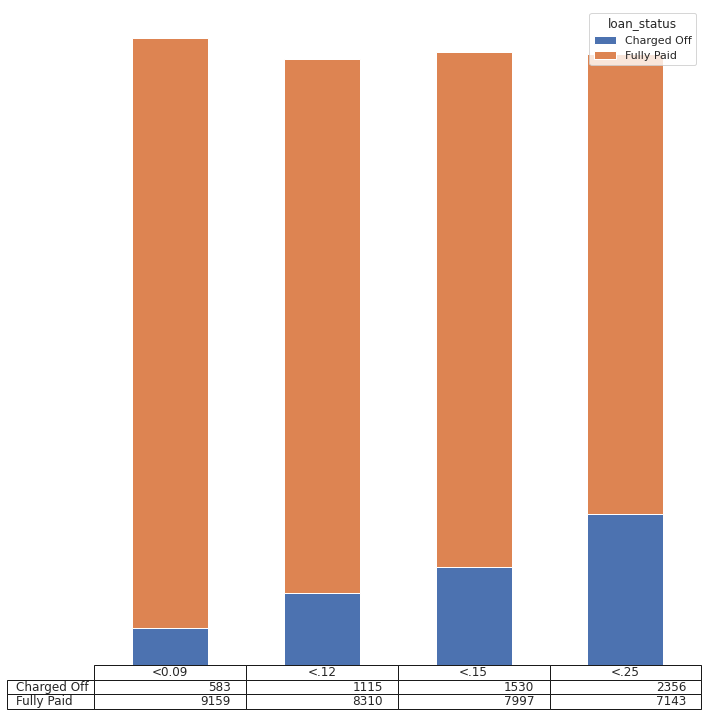

In [314]:
bar_plot('interest_bin' ,'loan_status', data=loans)

In [315]:
pd.crosstab([loans.interest_bin],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Fully Paid
interest_bin,,
<0.09,0.059844,0.940156
<.12,0.118302,0.881698
<.15,0.160596,0.839404
<.25,0.248026,0.751974


As the interest rates grow higher the chances of charging off  the loan increases.

In [316]:
pd.crosstab([loans.emp_length  ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Fully Paid
emp_length,,
1 year,0.144720,0.855280
10+ years,0.157529,0.842471
2 years,0.132155,0.867845
3 years,0.138547,0.861453
4 years,0.137515,0.862485
5 years,0.143939,0.856061
6 years,0.141795,0.858205
7 years,0.154390,0.845610
8 years,0.143058,0.856942


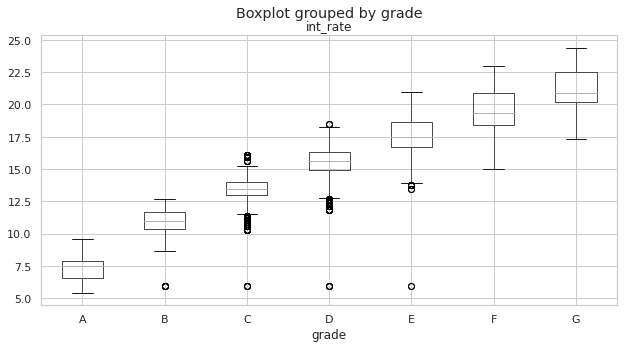

In [317]:
fig, ax = plt.subplots(figsize=(10,5))
loans.boxplot(column=['int_rate'],by='grade', ax=ax)
plt.show()

In [318]:
pd.crosstab([loans.emp_length , loans.interest_bin ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status              Charged Off  Fully Paid
emp_length interest_bin                         
1 year     <0.09         0.063584     0.936416  
           <.12          0.135301     0.864699  
           <.15          0.133858     0.866142  
           <.25          0.242667     0.757333  
10+ years  <0.09         0.062528     0.937472  
           <.12          0.118976     0.881024  
           <.15          0.176739     0.823261  
           <.25          0.274373     0.725627  
2 years    <0.09         0.050205     0.949795  
           <.12          0.097934     0.902066  
           <.15          0.150268     0.849732  
           <.25          0.226397     0.773603  
3 years    <0.09         0.058342     0.941658  
           <.12          0.094059     0.905941  
           <.15          0.161479     0.838521  
           <.25          0.242204     0.757796  
4 years    <0.09         0.050493     0.949507  
           <.12          0.131313     0.868687  
           <.15          0.122549     0.877451  
           <.25          0.235491     0.764509  
5 years    <0.09         0.057953     0.942047  
           <.12          0.115385     0.884615  
           <.15          0.162055     0.837945  
           <.25          0.239609     0.760391  
6 years    <0.09         0.053763     0.946237  
           <.12          0.100193     0.899807  
           <.15          0.162835     0.837165  
           <.25          0.250000     0.750000  
7 years    <0.09         0.042959     0.957041  
           <.12          0.135266     0.864734  
           <.15          0.178571     0.821429  
           <.25          0.254505     0.745495  
8 years    <0.09         0.051282     0.948718  
           <.12          0.122388     0.877612  
           <.15          0.159544     0.840456  
           <.25          0.250729     0.749271  
9 years    <0.09         0.060423     0.939577  
           <.12          0.091837     0.908163  
           <.15          0.149466     0.850534  
           <.25          0.220065     0.779935  
< 1 year   <0.09         0.062172     0.937828  
           <.12          0.125227     0.874773  
           <.15          0.156198     0.843802  
           <.25          0.231220     0.768780  
Not Given  <0.09         0.116456     0.883544  
           <.12          0.214559     0.785441  
           <.15          0.359756     0.640244  
           <.25          0.317308     0.682692

In [319]:
pd.crosstab([loans.grade , loans.interest_bin ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status         Charged Off  Fully Paid
grade interest_bin                         
A     <0.09         0.059125     0.940875  
      <.12          0.085308     0.914692  
B     <0.09         0.102273     0.897727  
      <.12          0.117263     0.882737  
      <.15          0.139264     0.860736  
C     <0.09         0.000000     1.000000  
      <.12          0.206107     0.793893  
      <.15          0.164857     0.835143  
      <.25          0.216554     0.783446  
D     <0.09         0.000000     1.000000  
      <.15          0.227041     0.772959  
      <.25          0.220855     0.779145  
E     <0.09         0.000000     1.000000  
      <.15          0.304348     0.695652  
      <.25          0.269632     0.730368  
F     <.25          0.327044     0.672956  
G     <.25          0.342561     0.657439

In [320]:
loans.open_acc.describe()

count    38193.000000
mean     9.257508    
std      4.392422    
min      2.000000    
25%      6.000000    
50%      9.000000    
75%      12.000000   
max      44.000000   
Name: open_acc, dtype: float64

In [321]:
loans.open_acc.quantile([0, .25,.50,0.75 ,1])

0.00    2.0 
0.25    6.0 
0.50    9.0 
0.75    12.0
1.00    44.0
Name: open_acc, dtype: float64

In [322]:
loans['open_acc_bin'] = pd.qcut(loans.open_acc, 4, labels=['2-6','7-9','10-12','13-44'],duplicates = 'drop')

In [323]:
loans.groupby('open_acc_bin')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
open_acc_bin,,,,,,,,
2-6,11257.0,4.718309,1.206759,2.0,4.0,5.0,6.0,6.0
7-9,11243.0,7.973406,0.814226,7.0,7.0,8.0,9.0,9.0
10-12,7855.0,10.885551,0.807095,10.0,10.0,11.0,12.0,12.0
13-44,7838.0,15.987114,3.227294,13.0,14.0,15.0,17.0,44.0


In [324]:
loans.open_acc_bin.unique()

[2-6, 10-12, 7-9, 13-44]
Categories (4, object): [2-6 < 7-9 < 10-12 < 13-44]

###Check Grade/Subgrade/Term

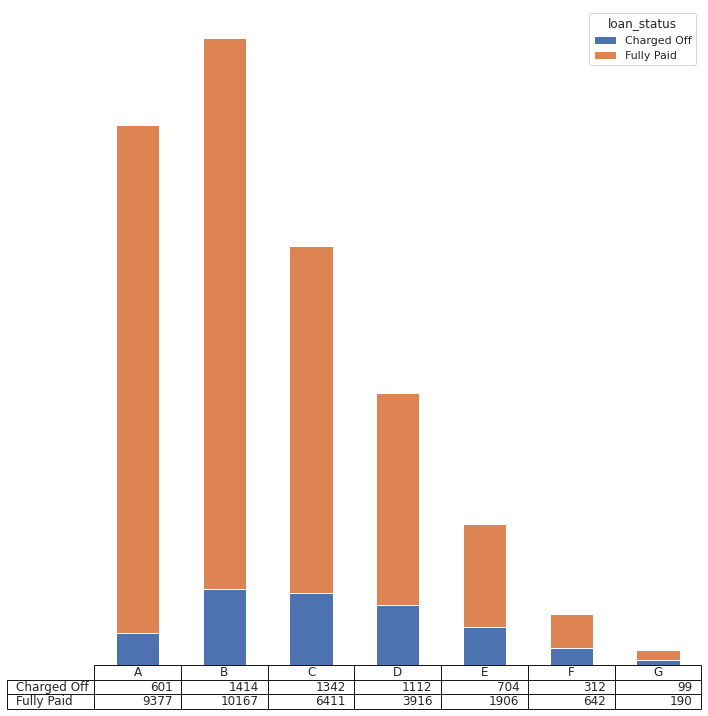

In [325]:
bar_plot('grade','loan_status', data=loans)

In [326]:
pd.crosstab(index = [loans.grade] , columns = loans.loan_status , values = loans.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status,Charged Off,Fully Paid
grade,,
A,0.060233,0.939767
B,0.122097,0.877903
C,0.173094,0.826906
D,0.221161,0.778839
E,0.269732,0.730268
F,0.327044,0.672956
G,0.342561,0.657439


In [327]:
pd.crosstab(index = [loans.term ,loans.grade] , columns = loans.loan_status , values = loans.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status      Charged Off  Fully Paid
term      grade                         
36 months A      0.058848     0.941152  
          B      0.105440     0.894560  
          C      0.147927     0.852073  
          D      0.180734     0.819266  
          E      0.202353     0.797647  
          F      0.253659     0.746341  
          G      0.363636     0.636364  
60 months A      0.093909     0.906091  
          B      0.188089     0.811911  
          C      0.242601     0.757399  
          D      0.291146     0.708854  
          E      0.302273     0.697727  
          F      0.347130     0.652870  
          G      0.337607     0.662393

In [395]:


pd.crosstab(index = [loans.term ,loans.grade,loans.sub_grade] , columns = loans.loan_status , values = loans.loan_amnt, aggfunc = 'count' , normalize= 'index')
#.stack().reset_index().rename(columns={0:'value'})


loan_status                Charged Off  Fully Paid
term      grade sub_grade                         
36 months A     A1         0.026502     0.973498  
                A2         0.049158     0.950842  
                A3         0.058020     0.941980  
                A4         0.060717     0.939283  
                A5         0.077980     0.922020  
          B     B1         0.089552     0.910448  
                B2         0.099295     0.900705  
                B3         0.105725     0.894275  
                B4         0.112832     0.887168  
                B5         0.116658     0.883342  
          C     C1         0.136770     0.863230  
                C2         0.140496     0.859504  
                C3         0.159259     0.840741  
                C4         0.148891     0.851109  
                C5         0.162685     0.837315  
          D     D1         0.178022     0.821978  
                D2         0.178304     0.821696  
                D3         0.192982     0.807018  
                D4         0.180698     0.819302  
                D5         0.171745     0.828255  
          E     E1         0.220641     0.779359  
                E2         0.210526     0.789474  
                E3         0.154321     0.845679  
                E4         0.188679     0.811321  
                E5         0.228261     0.771739  
          F     F1         0.241379     0.758621  
                F2         0.245283     0.754717  
                F3         0.258065     0.741935  
                F4         0.162162     0.837838  
                F5         0.423077     0.576923  
          G     G1         0.150000     0.850000  
                G2         0.333333     0.666667  
                G3         1.000000     0.000000  
                G4         0.333333     0.666667  
                G5         0.600000     0.400000  
60 months A     A2         0.071429     0.928571  
                A3         0.024390     0.975610  
                A4         0.100000     0.900000  
                A5         0.105023     0.894977  
          B     B1         0.146067     0.853933  
                B2         0.202899     0.797101  
                B3         0.169329     0.830671  
                B4         0.200972     0.799028  
                B5         0.199372     0.800628  
          C     C1         0.232236     0.767764  
                C2         0.229846     0.770154  
                C3         0.249357     0.750643  
                C4         0.277778     0.722222  
                C5         0.250000     0.750000  
          D     D1         0.384615     0.615385  
                D2         0.269807     0.730193  
                D3         0.277311     0.722689  
                D4         0.300000     0.700000  
                D5         0.316129     0.683871  
          E     E1         0.308585     0.691415  
                E2         0.293671     0.706329  
                E3         0.268222     0.731778  
                E4         0.338658     0.661342  
                E5         0.305755     0.694245  
          F     F1         0.307054     0.692946  
                F2         0.314607     0.685393  
                F3         0.306569     0.693431  
                F4         0.414414     0.585586  
                F5         0.512195     0.487805  
          G     G1         0.388889     0.611111  
                G2         0.370968     0.629032  
                G3         0.375000     0.625000  
                G4         0.214286     0.785714  
                G5         0.222222     0.777778

###Home Ownership ,Verification Status and Term

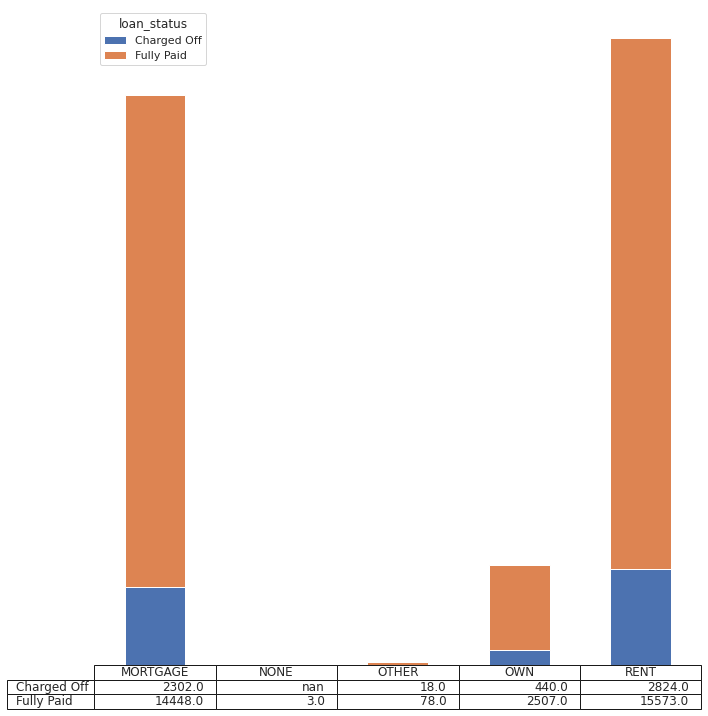

In [329]:
bar_plot('home_ownership','loan_status',data = loans)

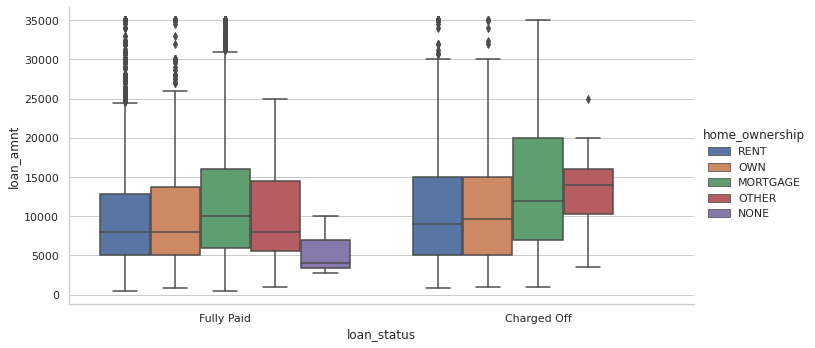

In [330]:
sns.catplot(x="loan_status", y="loan_amnt", hue="home_ownership", kind="box", data=loans,height=5, aspect=2)

In [331]:
pd.crosstab(index=  [loans.home_ownership],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
home_ownership,,
MORTGAGE,0.137433,0.862567
NONE,0.000000,1.000000
OTHER,0.187500,0.812500
OWN,0.149304,0.850696
RENT,0.153503,0.846497


In [332]:
pd.crosstab(index=  [loans.term,loans.home_ownership],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status               Charged Off  Fully Paid
term      home_ownership                         
36 months MORTGAGE        0.098848     0.901152  
          NONE            0.000000     1.000000  
          OTHER           0.178947     0.821053  
          OWN             0.109697     0.890303  
          RENT            0.120721     0.879279  
60 months MORTGAGE        0.229571     0.770429  
          OTHER           1.000000     0.000000  
          OWN             0.284431     0.715569  
          RENT            0.281117     0.718883

In [333]:
pd.crosstab(index= [loans.verification_status,loans.home_ownership,loans.term ] ,
            columns= [loans.loan_status] , values= loans.loan_amnt ,aggfunc= 'count',normalize= 'index')

loan_status                                   Charged Off  Fully Paid
verification_status home_ownership term                              
Not Verified        MORTGAGE       36 months  0.102412     0.897588  
                                   60 months  0.216049     0.783951  
                    NONE           36 months  0.000000     1.000000  
                    OTHER          36 months  0.176471     0.823529  
                                   60 months  1.000000     0.000000  
                    OWN            36 months  0.113885     0.886115  
                                   60 months  0.239766     0.760234  
                    RENT           36 months  0.122001     0.877999  
                                   60 months  0.234067     0.765933  
Source Verified     MORTGAGE       36 months  0.080943     0.919057  
                                   60 months  0.230449     0.769551  
                    OTHER          36 months  0.100000     0.900000  
                    OWN            36 months  0.093690     0.906310  
                                   60 months  0.312796     0.687204  
                    RENT           36 months  0.119317     0.880683  
                                   60 months  0.292625     0.707375  
Verified            MORTGAGE       36 months  0.105962     0.894038  
                                   60 months  0.235046     0.764954  
                    OTHER          36 months  0.205882     0.794118  
                    OWN            36 months  0.116034     0.883966  
                                   60 months  0.290210     0.709790  
                    RENT           36 months  0.119537     0.880463  
                                   60 months  0.297066     0.702934

###Purpose/Term

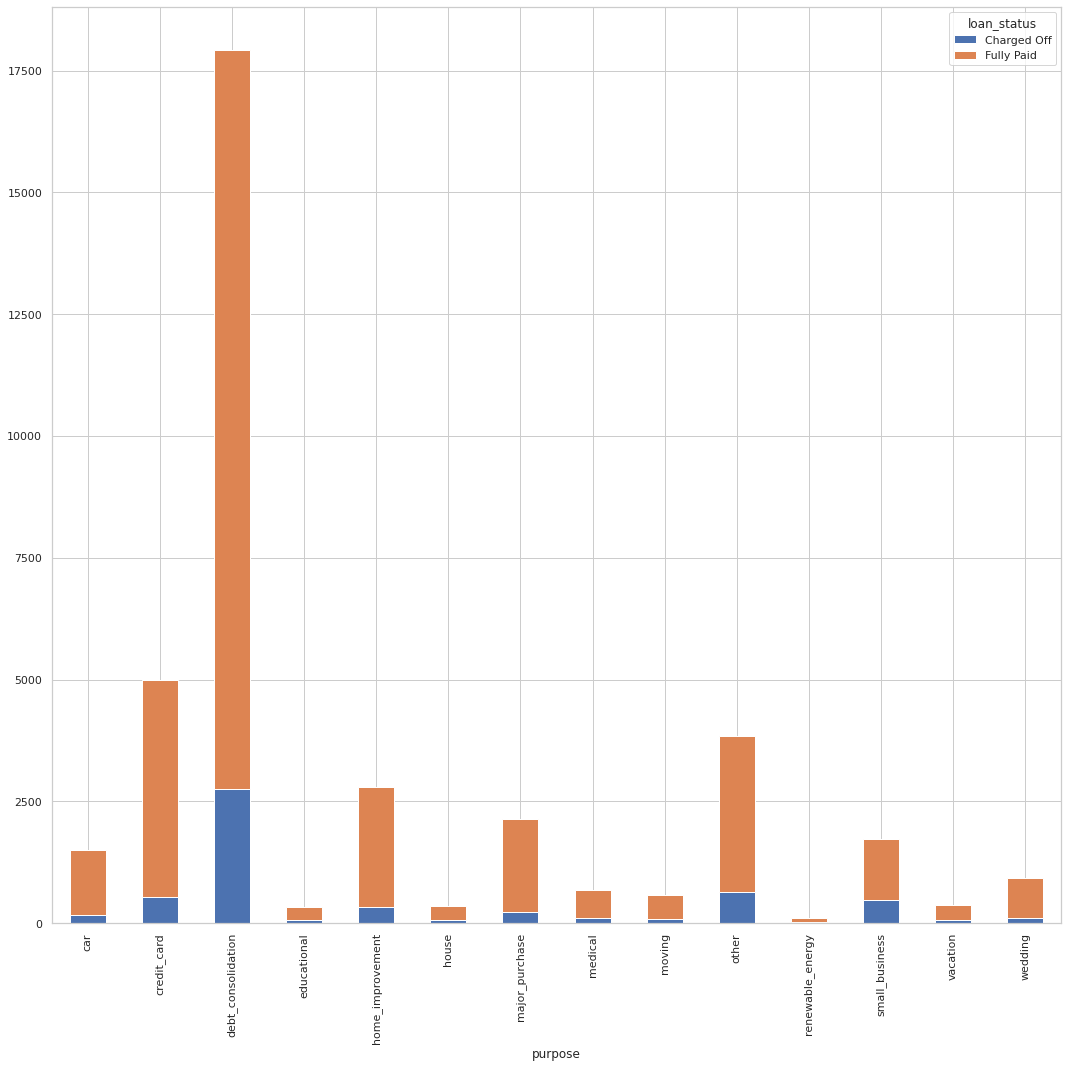

In [334]:
bar_plot('purpose', 'loan_status',data=loans, tabletoggle= False,sizecolumn= 15 , sizerow= 15,axistoggle= 'on')

In [335]:
pd.crosstab([loans.purpose],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Fully Paid
purpose,,
car,0.107239,0.892761
credit_card,0.107680,0.892320
debt_consolidation,0.153597,0.846403
educational,0.170279,0.829721
home_improvement,0.120844,0.879156
house,0.162465,0.837535
major_purchase,0.103335,0.896665
medical,0.157270,0.842730
moving,0.159649,0.840351


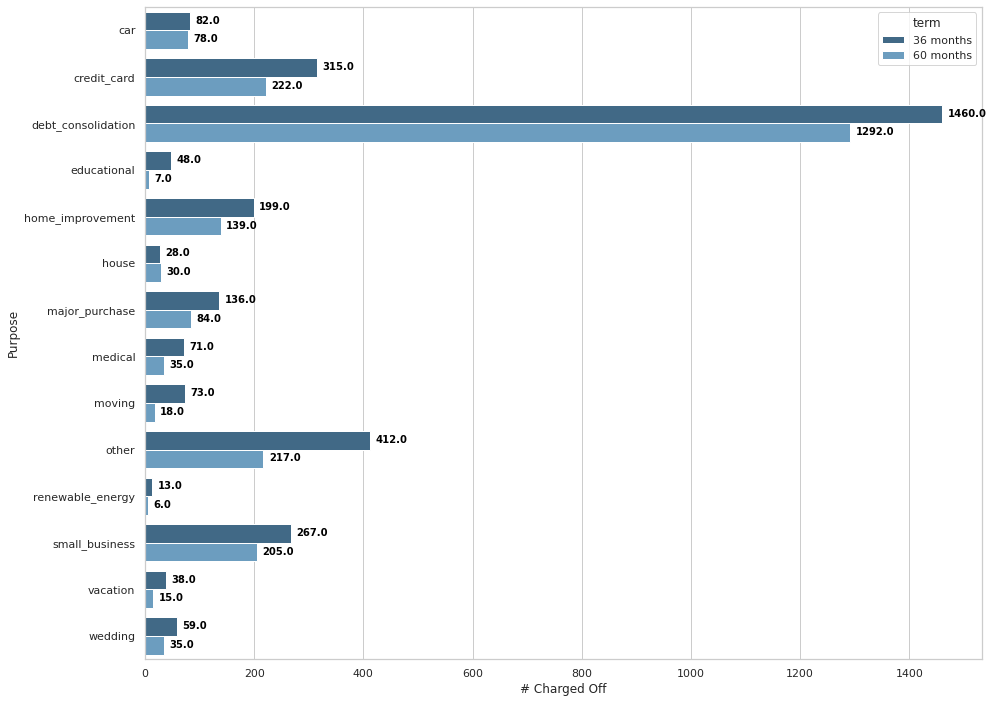

In [336]:
loans_d= pd.crosstab([loans.purpose ,loans.term ],[loans.loan_status],
                     values=loans.loan_amnt,aggfunc='count').reset_index().fillna(0)
fig, ax = plt.subplots(figsize=(15,12))
sns.set(style = 'whitegrid')
sns.barplot(x = 'Charged Off' ,y ='purpose',data =  loans_d ,hue = 
            'term' ,palette= 'Blues_d').set(
                xlabel ='# Charged Off' , ylabel= 'Purpose')
#to get values next to bar plots(THIS WILL THROW WARNINGS , WHICH IS IGNORED)
for i in ax.patches:
    ax.text(i.get_width()+10, i.get_y()+0.25, str(round((i.get_width()), 2)),
            fontsize=10, fontweight='bold', color='black')
plt.show()


In [337]:
pd.crosstab([loans.purpose ,loans.term ],[loans.loan_status],values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status                   Charged Off  Fully Paid
purpose            term                              
car                36 months  0.083588     0.916412  
                   60 months  0.152642     0.847358  
credit_card        36 months  0.077644     0.922356  
                   60 months  0.238710     0.761290  
debt_consolidation 36 months  0.111937     0.888063  
                   60 months  0.265080     0.734920  
educational        36 months  0.156352     0.843648  
                   60 months  0.437500     0.562500  
home_improvement   36 months  0.098710     0.901290  
                   60 months  0.177977     0.822023  
house              36 months  0.109804     0.890196  
                   60 months  0.294118     0.705882  
major_purchase     36 months  0.079579     0.920421  
                   60 months  0.200000     0.800000  
medical            36 months  0.136015     0.863985  
                   60 months  0.230263     0.769737  
moving             36 months  0.152401     0.847599  
                   60 months  0.197802     0.802198  
other              36 months  0.132263     0.867737  
                   60 months  0.302650     0.697350  
renewable_energy   36 months  0.173333     0.826667  
                   60 months  0.240000     0.760000  
small_business     36 months  0.219392     0.780608  
                   60 months  0.405138     0.594862  
vacation           36 months  0.118380     0.881620  
                   60 months  0.277778     0.722222  
wedding            36 months  0.081604     0.918396  
                   60 months  0.180412     0.819588

In [338]:
#df.verification_status,df.home_ownership,
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.crosstab([loans.verification_status,loans.purpose ,loans.term ],[loans.loan_status],values=loans.loan_amnt,aggfunc='count',
           normalize='index')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


loan_status                                       Charged Off  Fully Paid
verification_status purpose            term                              
Not Verified        car                36 months  0.070144     0.929856  
                                       60 months  0.123932     0.876068  
                    credit_card        36 months  0.077381     0.922619  
                                       60 months  0.209091     0.790909  
                    debt_consolidation 36 months  0.113991     0.886009  
                                       60 months  0.235474     0.764526  
                    educational        36 months  0.146789     0.853211  
                                       60 months  0.600000     0.400000  
                    home_improvement   36 months  0.106758     0.893242  
                                       60 months  0.179775     0.820225  
                    house              36 months  0.131579     0.868421  
                                       60 months  0.409091     0.590909  
                    major_purchase     36 months  0.084875     0.915125  
                                       60 months  0.162393     0.837607  
                    medical            36 months  0.153543     0.846457  
                                       60 months  0.224490     0.775510  
                    moving             36 months  0.133333     0.866667  
                                       60 months  0.192308     0.807692  
                    other              36 months  0.139612     0.860388  
                                       60 months  0.291667     0.708333  
                    renewable_energy   36 months  0.181818     0.818182  
                                       60 months  0.750000     0.250000  
                    small_business     36 months  0.226027     0.773973  
                                       60 months  0.442623     0.557377  
                    vacation           36 months  0.124183     0.875817  
                                       60 months  0.263158     0.736842  
                    wedding            36 months  0.082111     0.917889  
                                       60 months  0.093750     0.906250  
Source Verified     car                36 months  0.080153     0.919847  
                                       60 months  0.168539     0.831461  
                    credit_card        36 months  0.081590     0.918410  
                                       60 months  0.277512     0.722488  
                    debt_consolidation 36 months  0.104992     0.895008  
                                       60 months  0.271186     0.728814  
                    educational        36 months  0.107143     0.892857  
                                       60 months  0.250000     0.750000  
                    home_improvement   36 months  0.094092     0.905908  
                                       60 months  0.197425     0.802575  
                    house              36 months  0.132353     0.867647  
                                       60 months  0.375000     0.625000  
                    major_purchase     36 months  0.065909     0.934091  
                                       60 months  0.251748     0.748252  
                    medical            36 months  0.114865     0.885135  
                                       60 months  0.245283     0.754717  
                    moving             36 months  0.205882     0.794118  
                                       60 months  0.264706     0.735294  
                    other              36 months  0.116959     0.883041  
                                       60 months  0.327189     0.672811  
                    renewable_energy   36 months  0.107143     0.892857  
                                       60 months  0.100000     0.900000  
                    small_business     36 months  0.185185     0.814815  
                                       60 months  0.373563     0.626437  
    

Long term loans for vacation , education ,small business ,credit card or for no reasons is a bad idea